In [1]:
import pandas as pd
import numpy as np

from scipy import stats, odr

from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

# Reading Cleaned Data

In [2]:
df = pd.read_pickle('data.pkl')

In [3]:
# Data types
df.dtypes

Sex           object
Event         object
Age          float64
Tested        object
Squat        float64
Bench        float64
Dead         float64
Total        float64
Weight        object
AgeGroup    category
dtype: object

# Removing Non Drug Tested Competitions

Data Exploration and Statistical Testing will be first performed separately and the results will be compared at the end.


In [4]:
df = df[df['Tested']=='Yes'].reset_index(drop = True)

# Stratifying Strength Data

Total = Weight of all three lifts combined (must have three at one competition)

Deadlift = Weight of maximum deadlift

Bench Press = Weight of maximum bench press

Squat = Weight of maximum squat

In [5]:
total = df[(df['Event']=='SBD')&\
          (df['Total'].notnull())&(df['Total']>0)].reset_index(drop = True)[['Sex','Age','Tested','Total','Weight','AgeGroup']].copy()

dead = df[(df['Dead'].notnull())&\
         (df['Dead']>0)].reset_index(drop = True)[['Sex','Age','Tested','Dead','Weight','AgeGroup']].copy()

bench = df[(df['Bench'].notnull())&\
          (df['Bench']>0)].reset_index(drop = True)[['Sex','Age','Tested','Bench','Weight','AgeGroup']].copy()

squat = df[(df['Squat'].notnull())&\
          (df['Squat']>0)].reset_index(drop = True)[['Sex','Age','Tested','Squat','Weight','AgeGroup']].copy()

# Modifying Population For "Average" Lifters
Average defined as a weight lifted between .25 and .75 quantile (IQR) of each weight group regardless of age

In [6]:
def average_weights(total):
    col = total.columns[3]
    btm = total.groupby('Weight')[col].quantile(.25).reset_index().copy() 
    btm.columns = ['Weight','Low']
    top = total.groupby('Weight')[col].quantile(.75).reset_index().copy() 
    top.columns = ['Weight','High']
    total = pd.merge(pd.merge(total,btm,
                              how = 'inner', on = 'Weight'),top, how = 'inner',on = 'Weight')
    total = total[(total[col]>=total['Low'])&(total[col]<=total['High'])].reset_index(drop = True).drop(['High','Low'], axis = 1)
    return total

In [7]:
total = average_weights(total) 
dead = average_weights(dead) 
squat = average_weights(squat) 
bench = average_weights(bench)

# Visualizations - Age, Weight, Strength

In [8]:
def quadrant(total,bench,squat,dead,sex,plot):
    fig,axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))

    axs[0,0].set_title('Age and Total Weight Lifted for '+sex)
    axs[0,1].set_title('Age and Bench Press for '+sex)
    axs[1,0].set_title('Age and Squat for '+sex)
    axs[1,1].set_title('Age and Deadlift for '+sex)

    common_xlim = (min(df['Age'])-10, max(df['Age'])+20)
    
    axs[0, 0].set_xlim(common_xlim)
    axs[0, 1].set_xlim(common_xlim)
    axs[1, 0].set_xlim(common_xlim)
    axs[1, 1].set_xlim(common_xlim)
    
    if plot == 'Scatter':
        sns.scatterplot(data=total[total['Sex'] == sex].copy(), x='Age', y='Total', color='steelblue', ax=axs[0, 0])
        sns.scatterplot(data=bench[bench['Sex'] == sex].copy(), x='Age', y='Bench', color='steelblue', ax=axs[0, 1])
        sns.scatterplot(data=squat[squat['Sex'] == sex].copy(), x='Age', y='Squat', color='steelblue', ax=axs[1, 0])
        sns.scatterplot(data=dead[dead['Sex'] == sex].copy(), x='Age', y='Dead', color='steelblue', ax=axs[1, 1])
        plt.tight_layout()
    elif plot == 'Box':
        sns.boxplot(data=total[total['Sex'] == sex].copy(), x='AgeGroup', y='Total', color='steelblue', ax=axs[0, 0])
        sns.boxplot(data=bench[bench['Sex'] == sex].copy(), x='AgeGroup', y='Bench', color='steelblue', ax=axs[0, 1])
        sns.boxplot(data=squat[squat['Sex'] == sex].copy(), x='AgeGroup', y='Squat', color='steelblue', ax=axs[1, 0])
        sns.boxplot(data=dead[dead['Sex'] == sex].copy(), x='AgeGroup', y='Dead', color='steelblue', ax=axs[1, 1])
        plt.tight_layout()

Sex = M

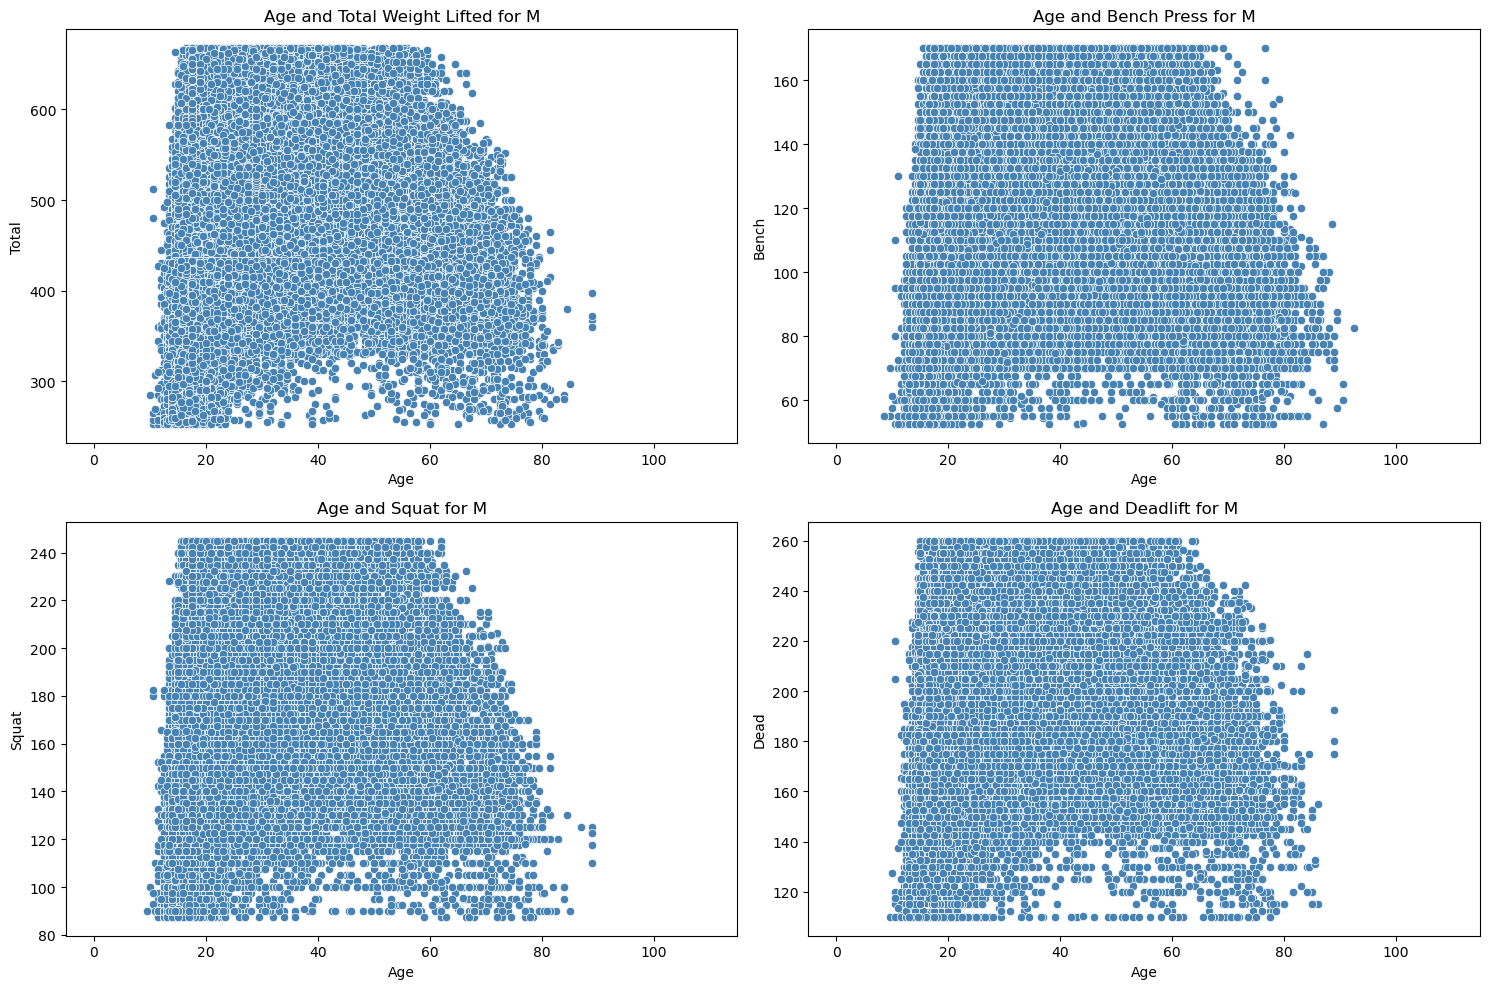

In [9]:
quadrant(total,bench,squat,dead,'M','Scatter')

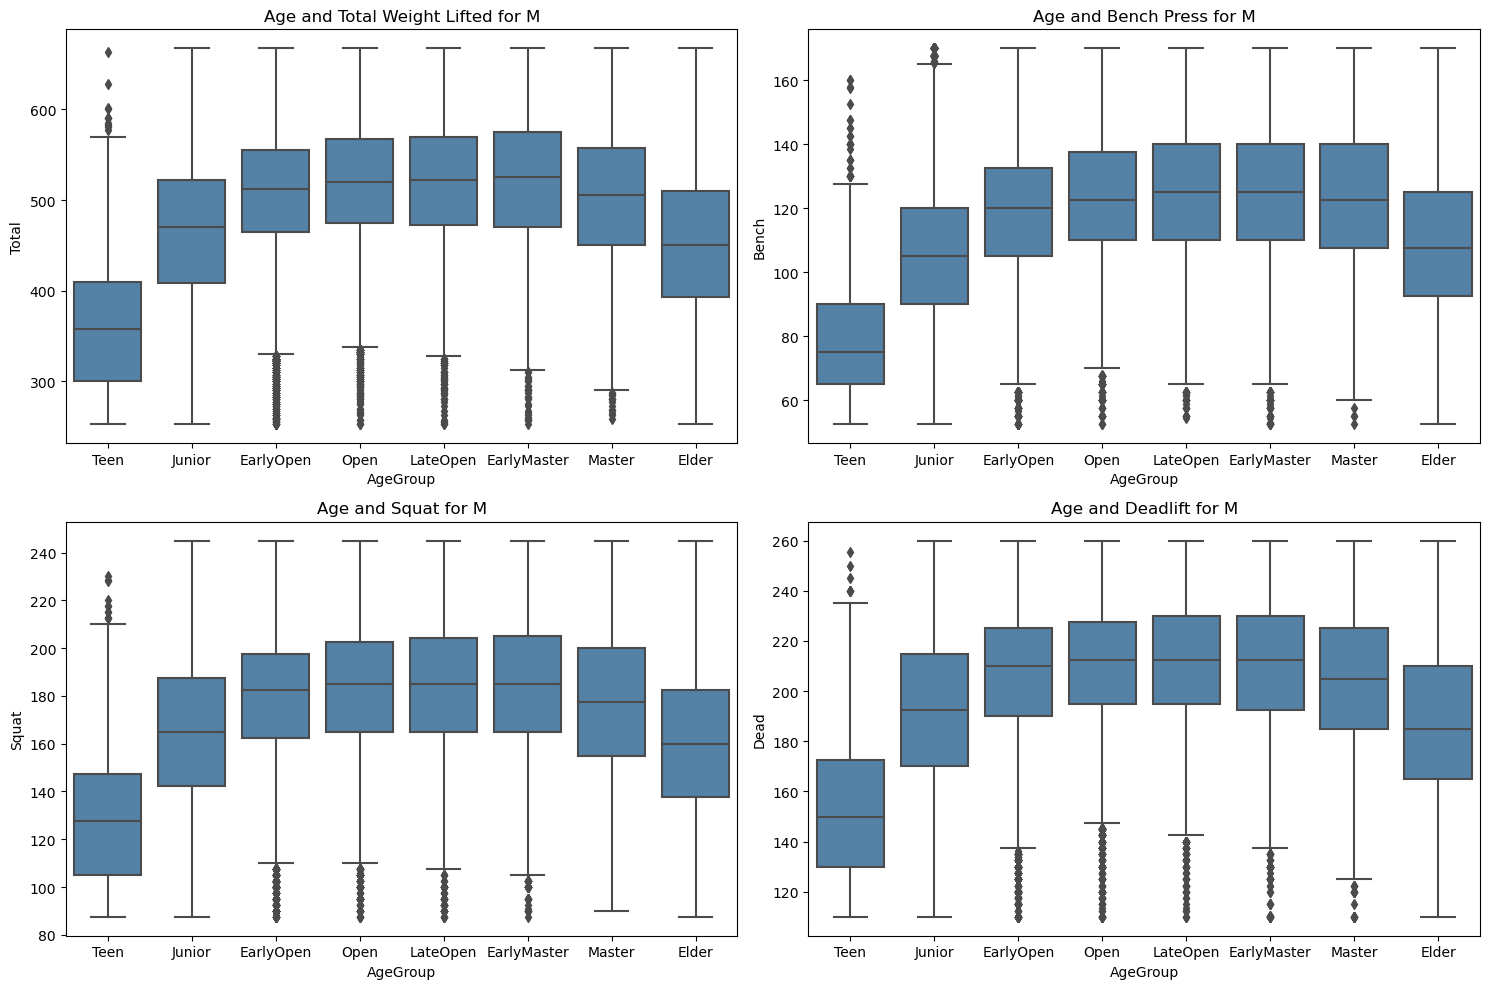

In [10]:
quadrant(total,bench,squat,dead,'M','Box')

Sex = F

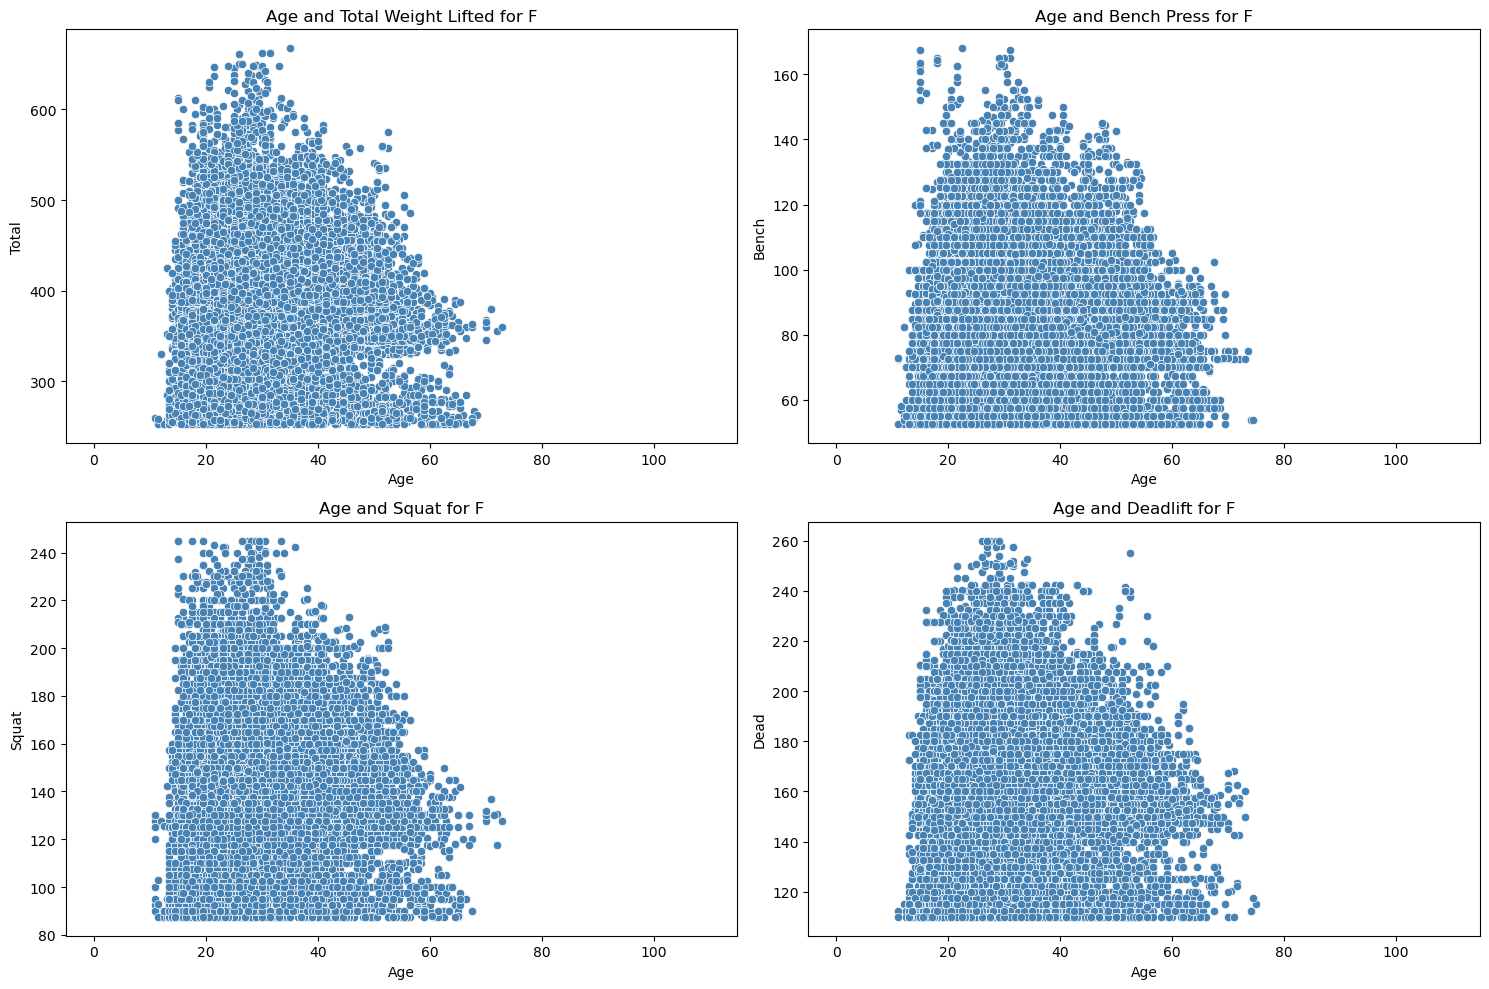

In [11]:
# Female
quadrant(total,bench,squat,dead,'F','Scatter')

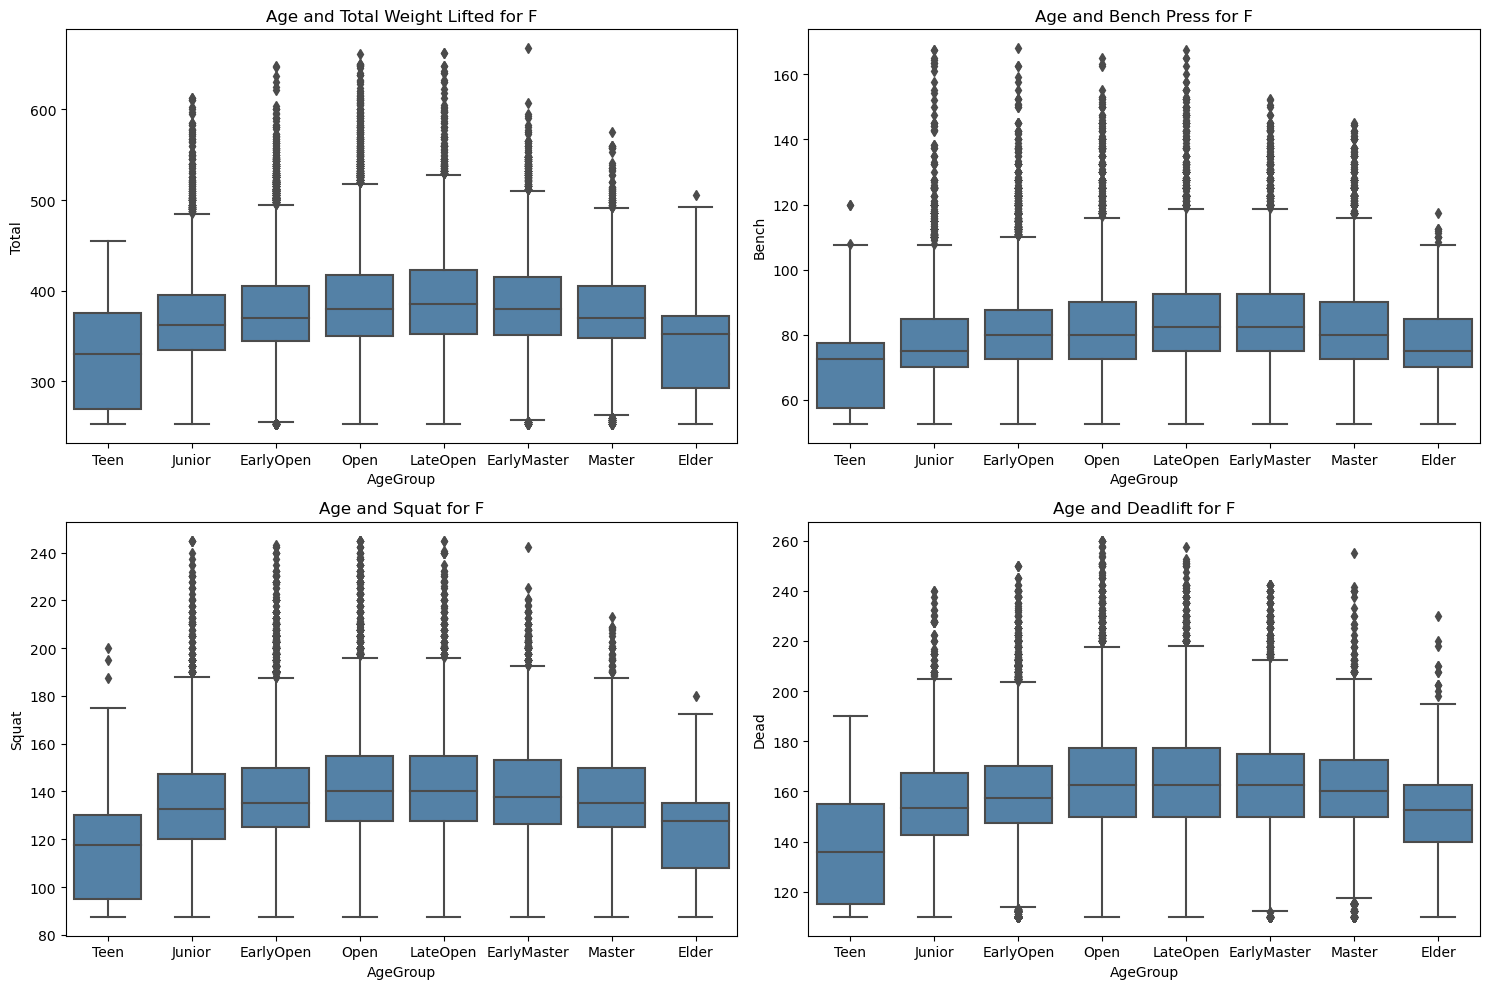

In [12]:
quadrant(total,bench,squat,dead,'F','Box')

Take a random sample for each age group

In [13]:
age_groups = df['AgeGroup'].unique()

def sample(total, n):
    dfs = pd.DataFrame()
    for x in range(len(age_groups)):
        a = total[total['AgeGroup']==age_groups[x]].copy()
        aa = a.sample(n = 500).copy()
        dfs = pd.concat([dfs,aa], axis = 0, ignore_index = True)
    return dfs

Sex = M

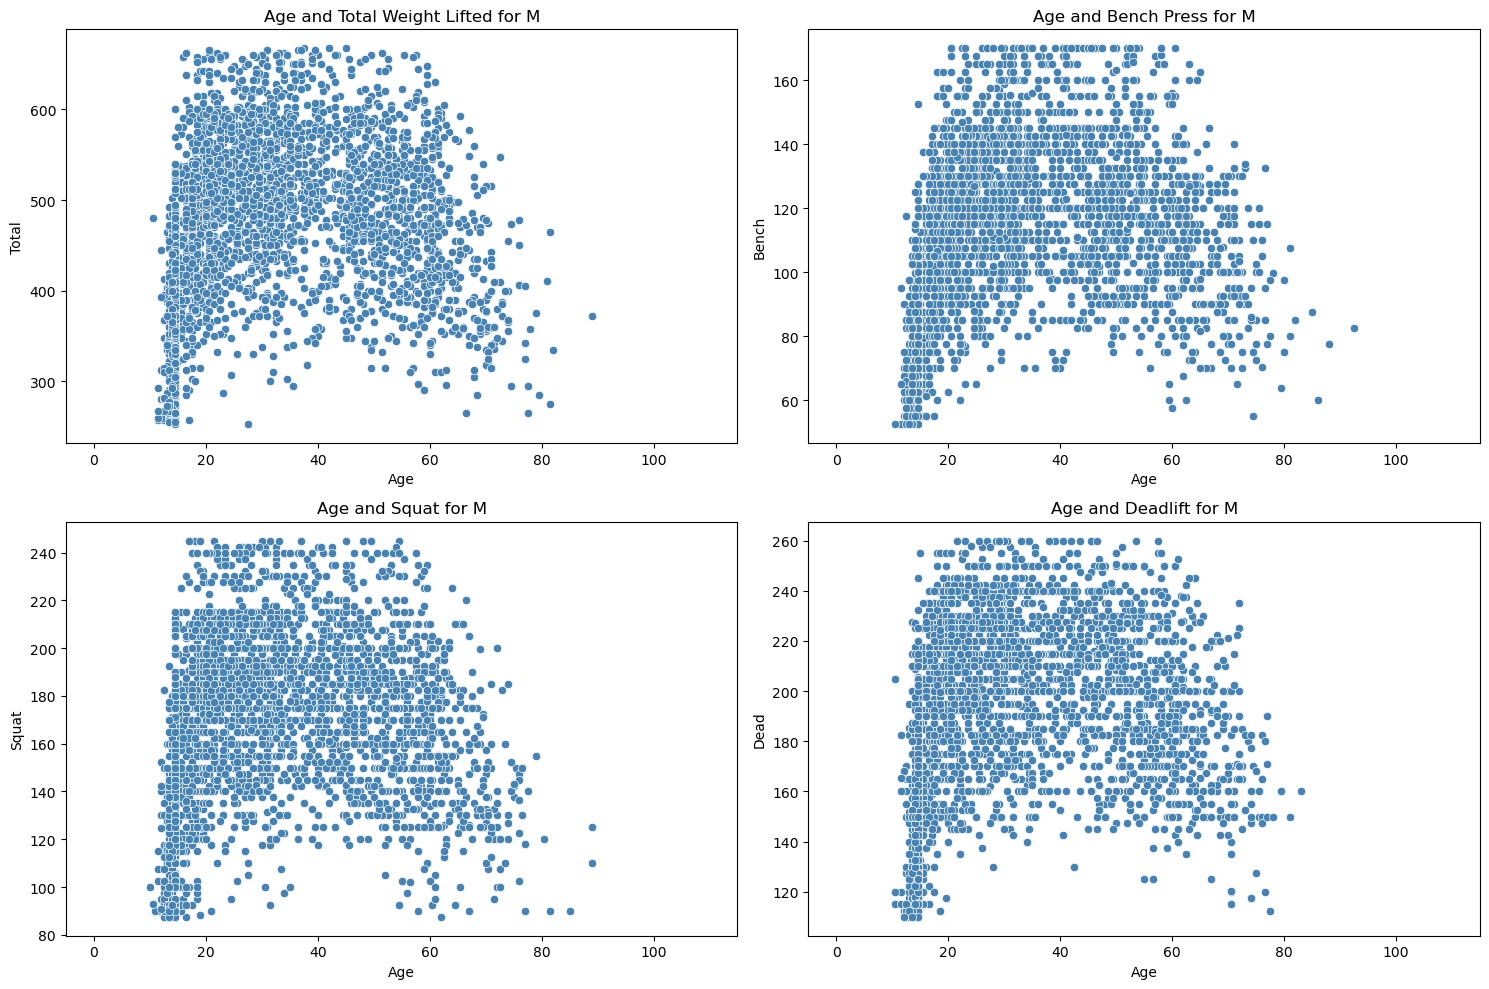

In [14]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Scatter')

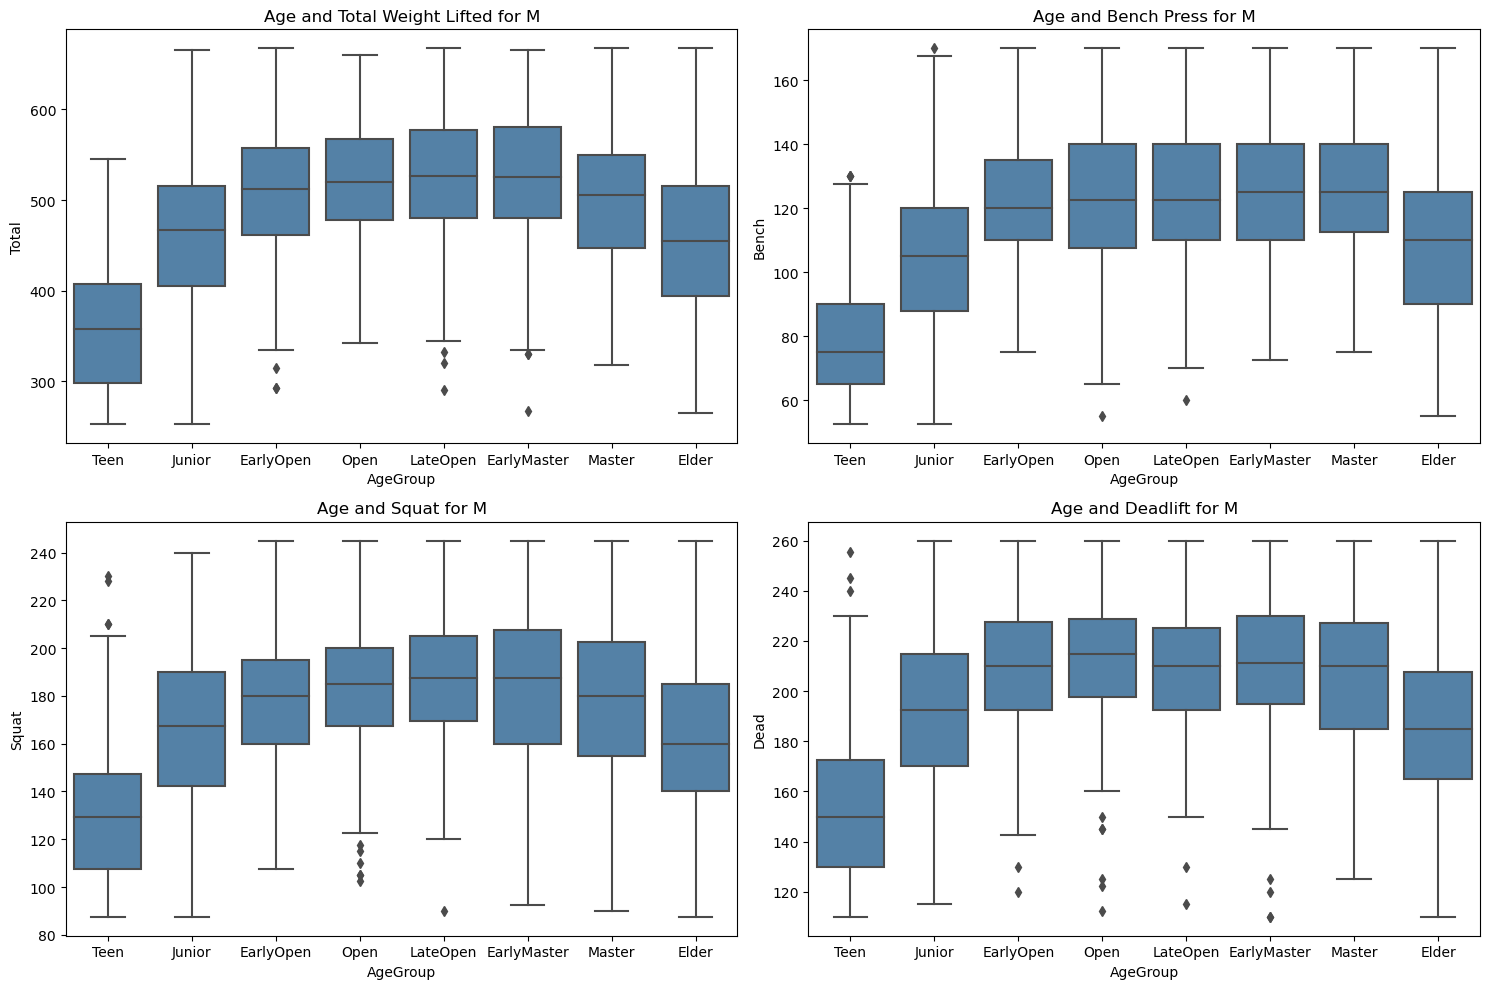

In [15]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Box')

Sex = F

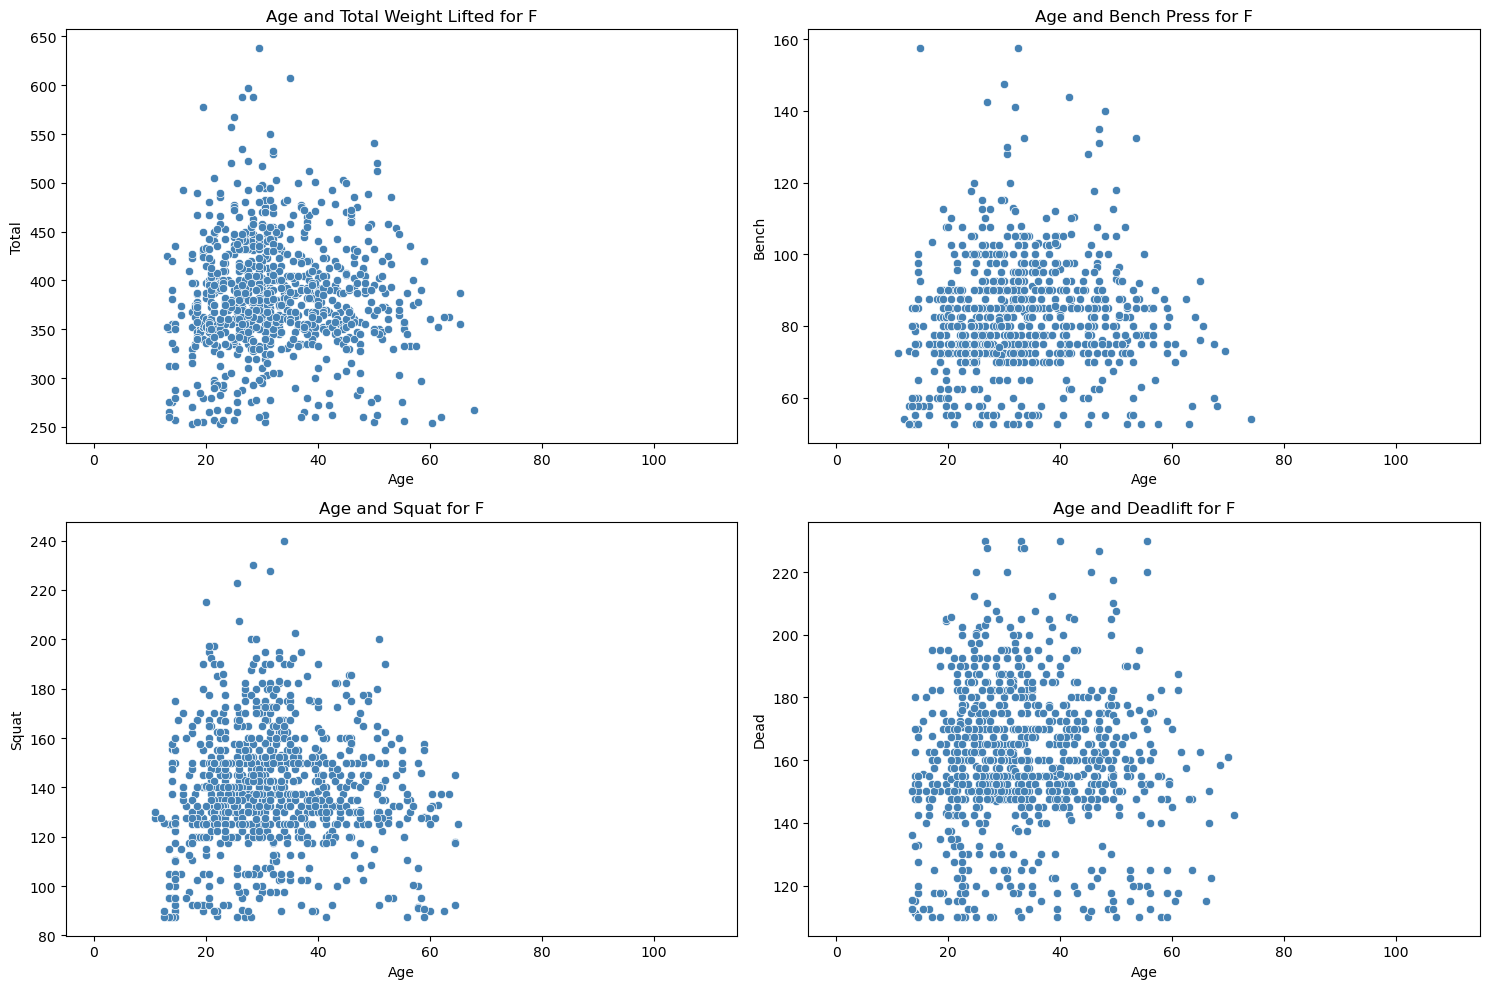

In [16]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Scatter')

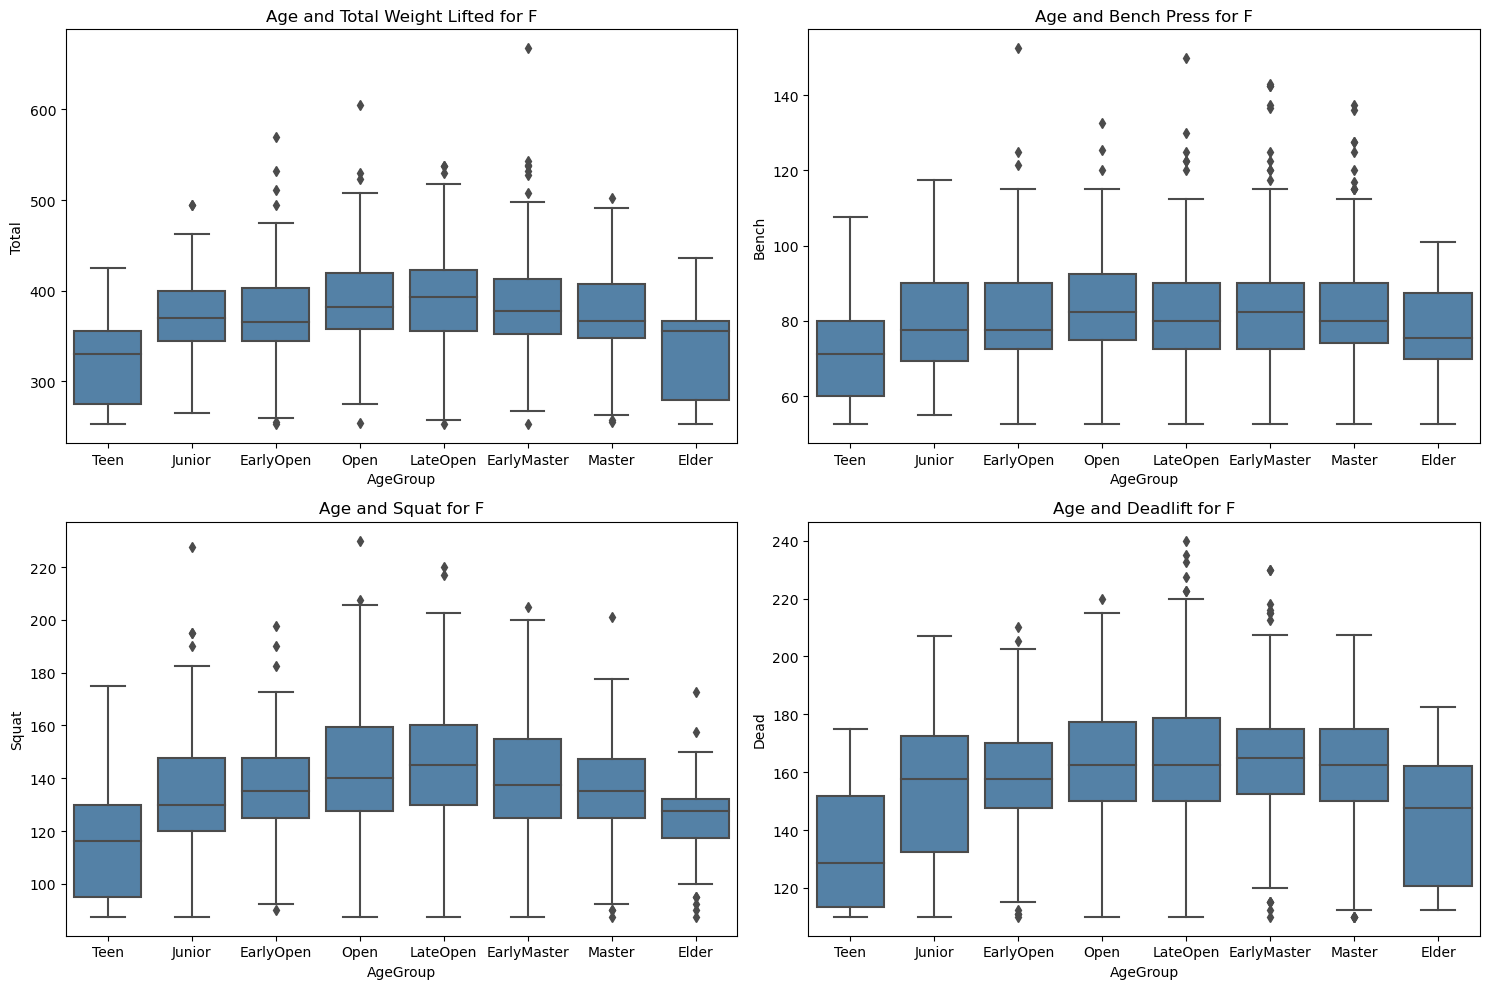

In [17]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Box')

Random Selected Sample Scatter Plot with Hue

In [18]:
def quadrant_hue(total,bench,squat,dead,sex,hue,group):
    fig,axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))
    if group == 'Lighter':
        total = total[total['Weight'].isin(['Light','Middle'])]
        dead = dead[dead['Weight'].isin(['Light','Middle'])]
        squat = squat[squat['Weight'].isin(['Light','Middle'])]
        bench = bench[bench['Weight'].isin(['Light','Middle'])]
    elif group == 'Heavier':
        total = total[total['Weight'].isin(['Heavy','SuperHeavy'])]
        dead = dead[dead['Weight'].isin(['Heavy','SuperHeavy'])]
        squat = squat[squat['Weight'].isin(['Heavy','SuperHeavy'])]
        bench = bench[bench['Weight'].isin(['Heavy','SuperHeavy'])]
    
    axs[0,0].set_title('Age and Total Weight Lifted for '+sex)
    axs[0,1].set_title('Age and Bench Press for '+sex)
    axs[1,0].set_title('Age and Squat for '+sex)
    axs[1,1].set_title('Age and Deadlift for '+sex)

    common_xlim = (min(df['Age'])-10, max(df['Age'])+20)
    
    axs[0, 0].set_xlim(common_xlim)
    axs[0, 1].set_xlim(common_xlim)
    axs[1, 0].set_xlim(common_xlim)
    axs[1, 1].set_xlim(common_xlim)

    hue_order = total[hue].unique()

    palette = sns.color_palette('Accent', n_colors=len(hue_order))

    sns.scatterplot(data=total[total['Sex'] == sex].copy(), x='Age', y='Total', ax=axs[0, 0],
                    hue=hue, palette=palette, hue_order=hue_order)
    sns.scatterplot(data=bench[bench['Sex'] == sex].copy(), x='Age', y='Bench', ax=axs[0, 1],
                    hue=hue, palette=palette, hue_order=hue_order)
    sns.scatterplot(data=squat[squat['Sex'] == sex].copy(), x='Age', y='Squat', ax=axs[1, 0],
                    hue=hue, palette=palette, hue_order=hue_order)
    sns.scatterplot(data=dead[dead['Sex'] == sex].copy(), x='Age', y='Dead', ax=axs[1, 1],
                    hue=hue, palette=palette, hue_order=hue_order)
    plt.tight_layout()

Sex = M

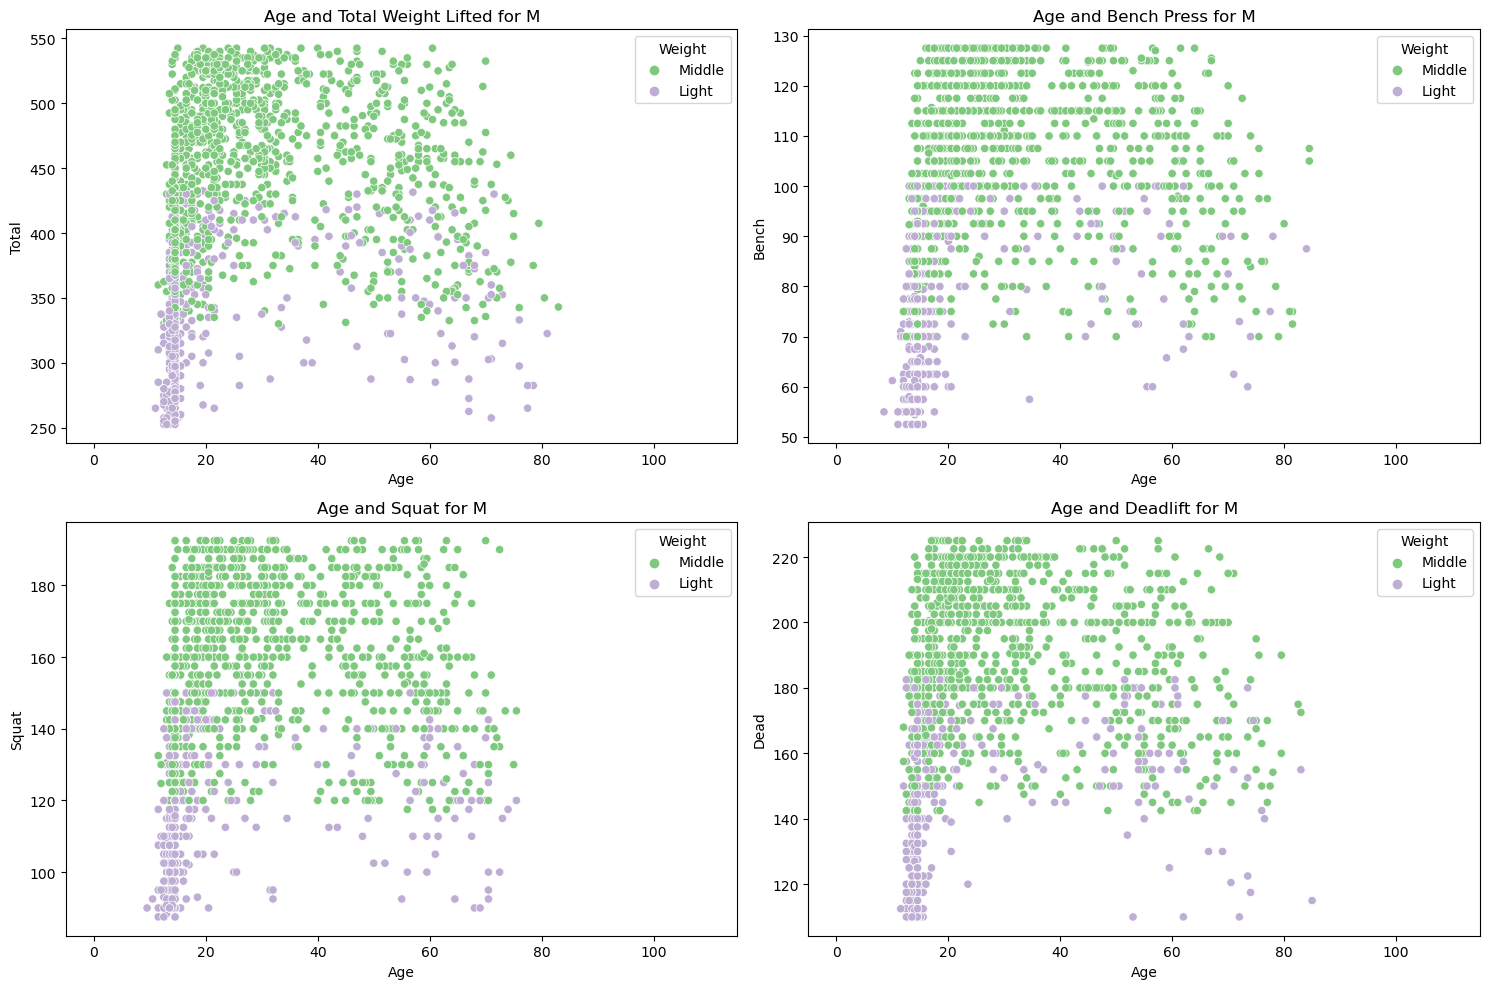

In [19]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Weight','Lighter')

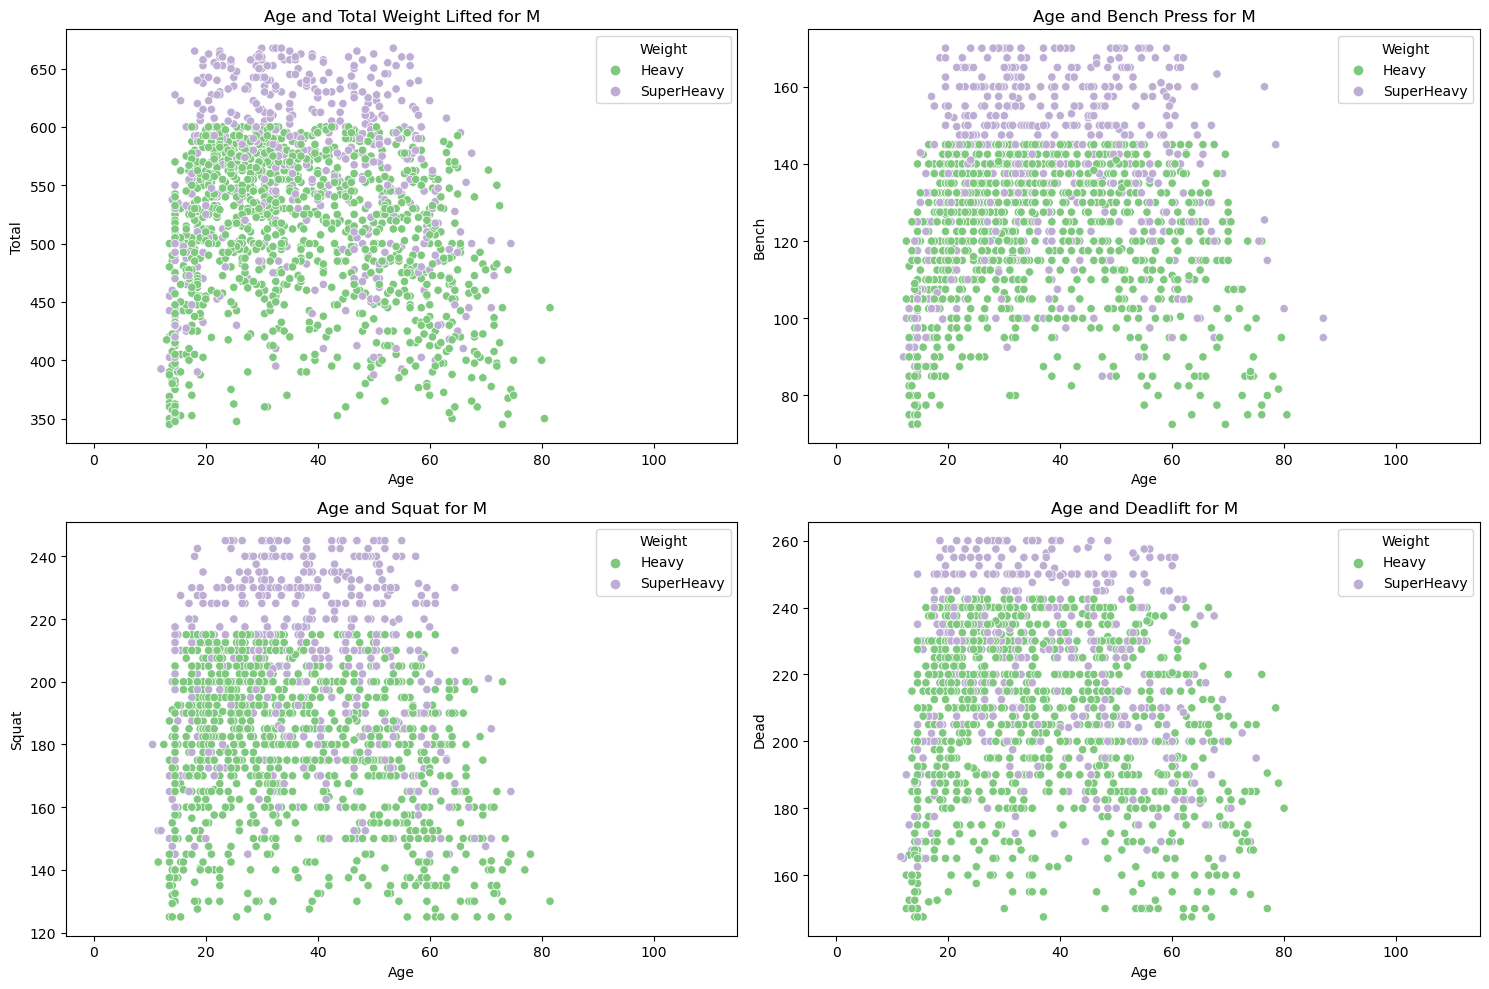

In [20]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Weight','Heavier')

Sex = F

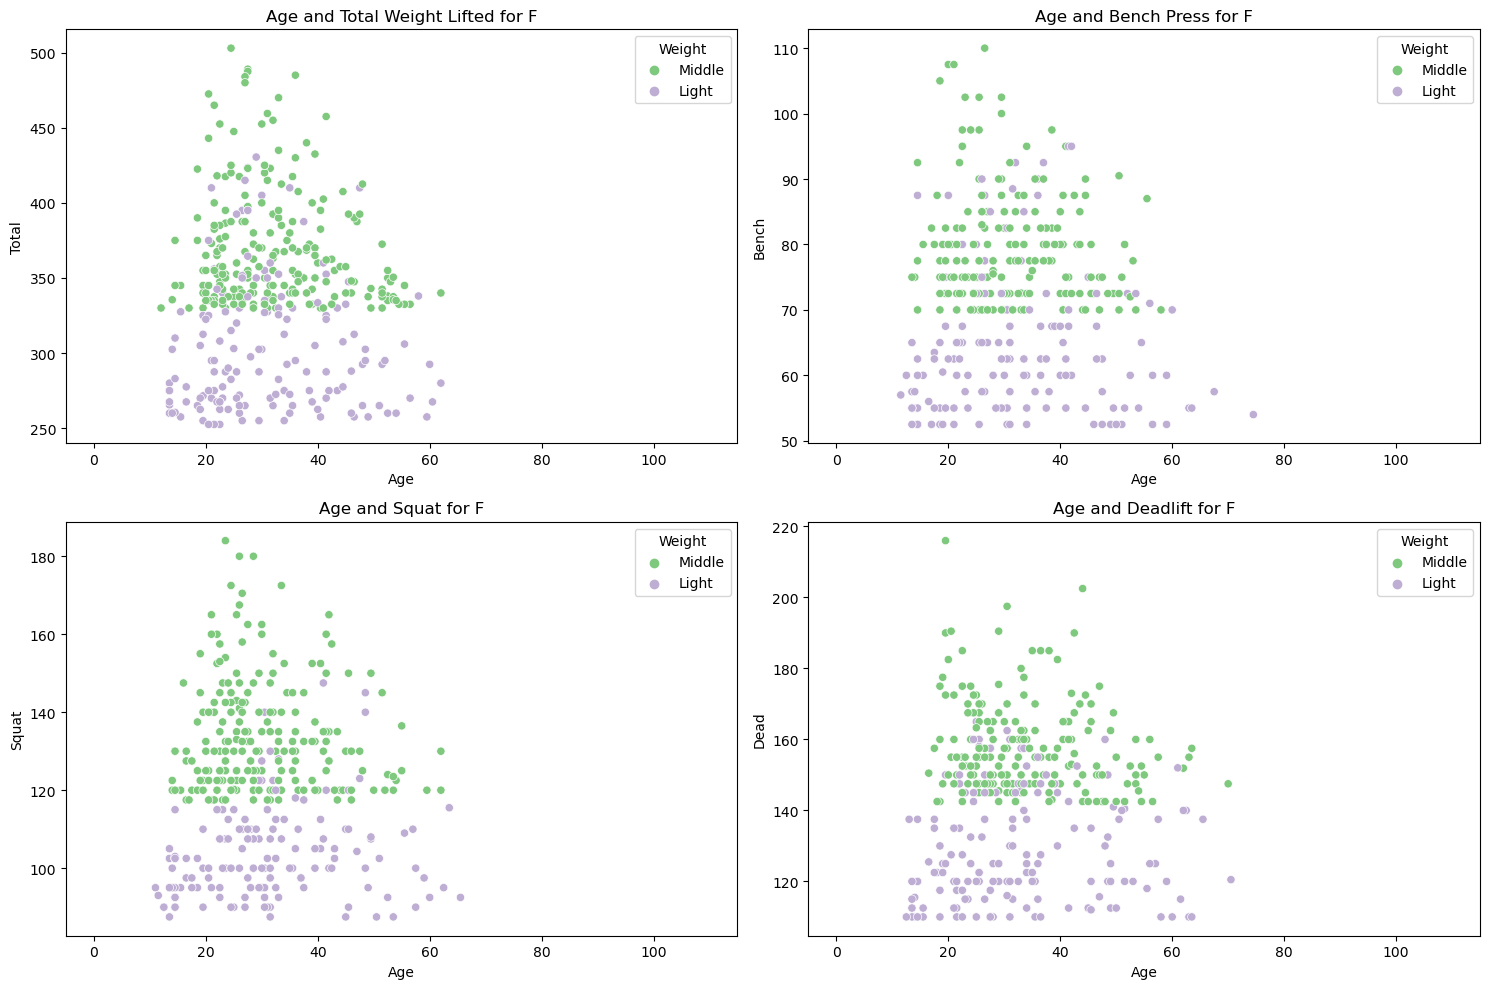

In [21]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Weight','Lighter')

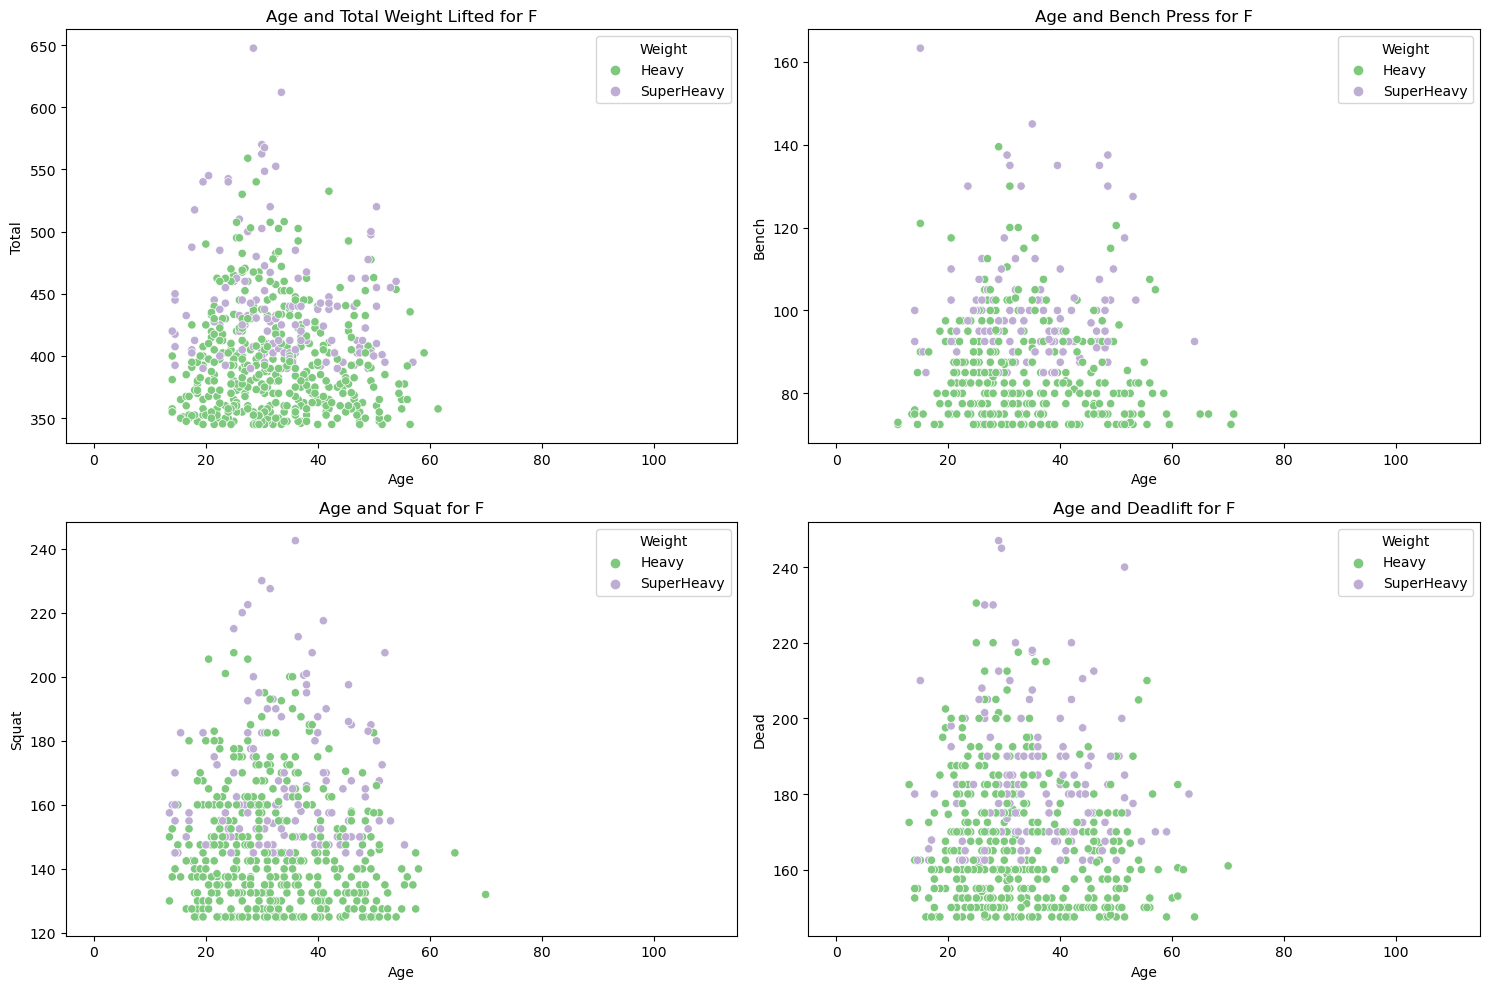

In [22]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Weight','Heavier')

# 1) Gaussian Distribution

Explore normality between Age Groups and Peak Strength levels across Total, Bench, Dead, and Squat

In [23]:
def max_strength(total, sex):
    summary = pd.DataFrame()
    col = total.columns[3]
    cutoff = total[total['Sex'] == sex].groupby('AgeGroup')[col].quantile(.9).reset_index().copy()
    return cutoff

def shapiro_wilk(total, sex, alpha):
    a = max_strength(total, sex)
    col = total.columns[3]
    stat, p = stats.shapiro(a[col])
    if p > alpha:
        return 'The data appears to be normally distributed (fail to reject H0)'
    else:
        return 'The data does not appear to be normally distributed (reject H0)'
        
def bar_quadrant(total, bench, squat, dead, sex):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

    axs[0, 0].set_title('Top Total per Age Group for ' + sex)
    axs[0, 1].set_title('Top Bench Press per Age Group for ' + sex)
    axs[1, 0].set_title('Top Squat per Age Group for ' + sex)
    axs[1, 1].set_title('Top Deadlift per Age Group for ' + sex)

    sns.barplot(max_strength(total, sex), x='AgeGroup', y='Total', color='steelblue', ax=axs[0, 0])
    sns.barplot(max_strength(bench, sex), x='AgeGroup', y='Bench', color='steelblue', ax=axs[0, 1])
    sns.barplot(max_strength(squat, sex), x='AgeGroup', y='Squat', color='steelblue', ax=axs[1, 0])
    sns.barplot(max_strength(dead, sex), x='AgeGroup', y='Dead', color='steelblue', ax=axs[1, 1])
    
    total_conclusion = shapiro_wilk(total, sex, alpha=0.05)
    bench_conclusion = shapiro_wilk(bench, sex, alpha=0.05)
    squat_conclusion = shapiro_wilk(squat, sex, alpha=0.05)
    dead_conclusion = shapiro_wilk(dead, sex, alpha=0.05)
    for ax in axs.flat:
        for bar in ax.patches:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                    round(bar.get_height(), 2), ha='center', va='bottom')
        
    axs[0, 0].text(0.5, -0.2, total_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[0, 0].transAxes, fontsize=10, color='red')
    axs[0, 1].text(0.5, -0.2, bench_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[0, 1].transAxes, fontsize=10, color='red')
    axs[1, 0].text(0.5, -0.2, squat_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[1, 0].transAxes, fontsize=10, color='red')
    axs[1, 1].text(0.5, -0.2, dead_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[1, 1].transAxes, fontsize=10, color='red')

    plt.tight_layout()


Null Hypothesis: The distribution of Top Strength per Age Group is normally distributed.

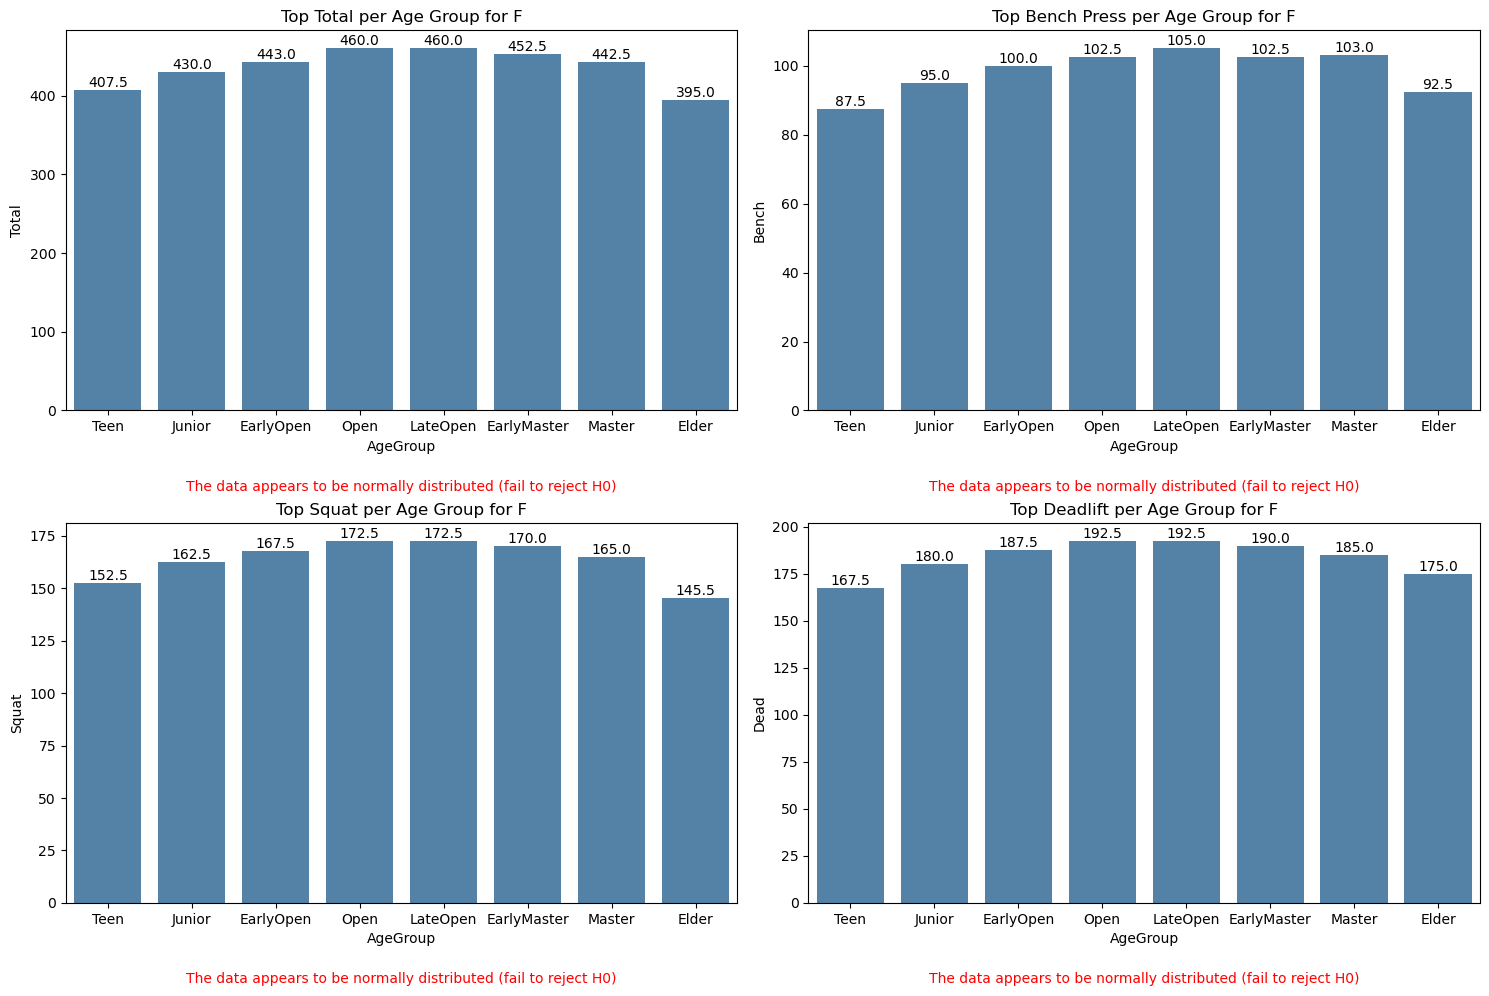

In [24]:
bar_quadrant(total,bench,squat,dead,'F')

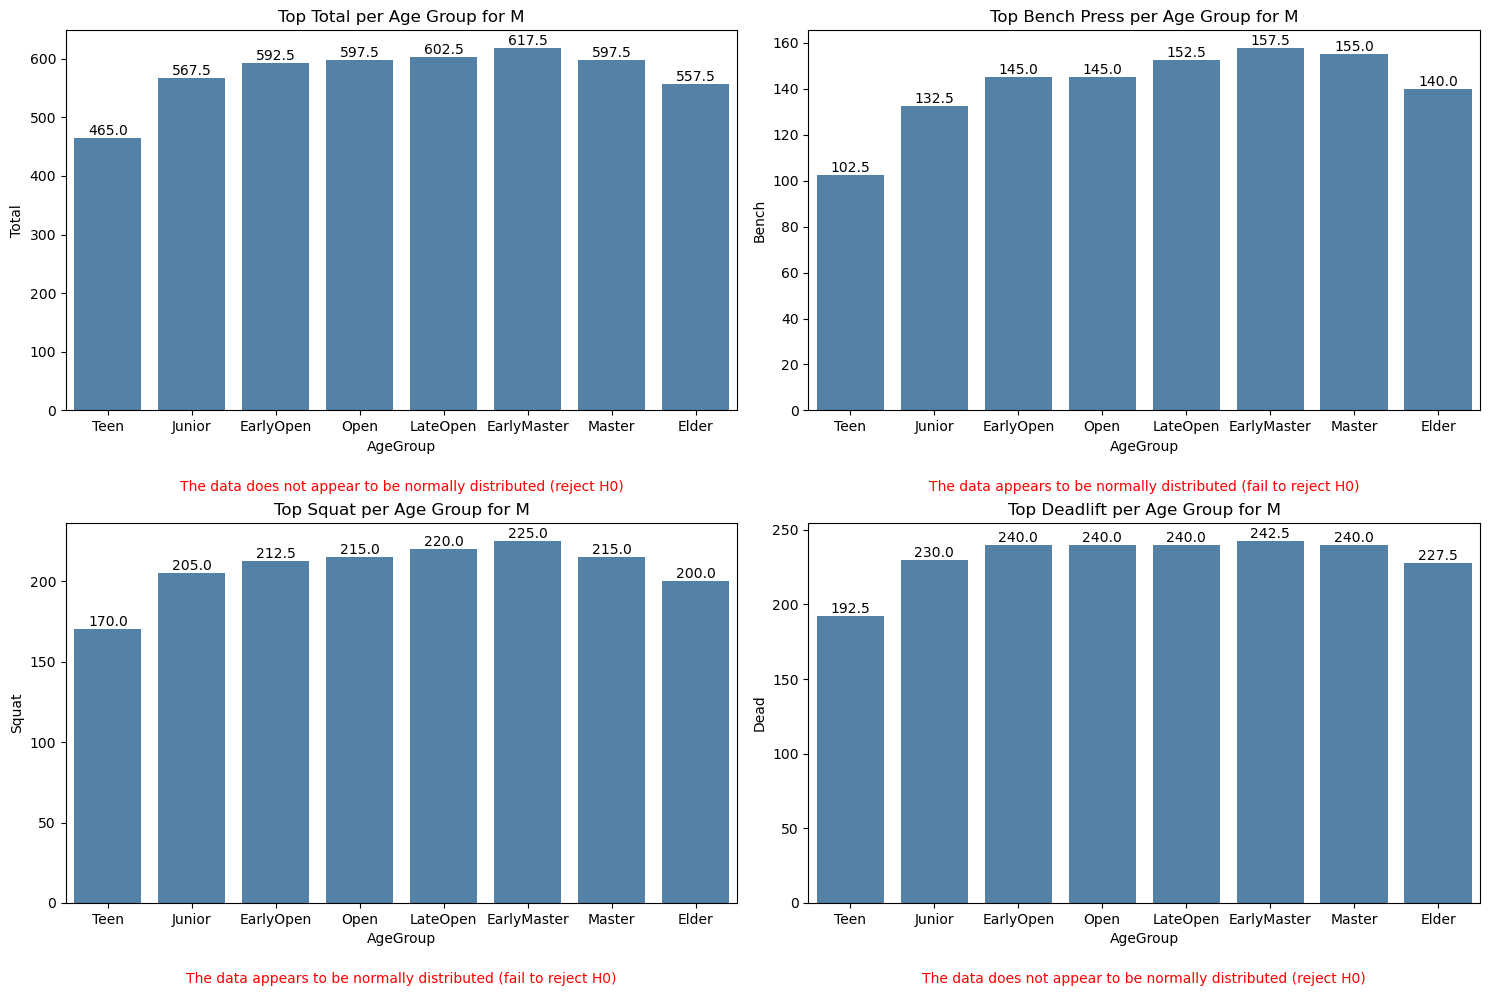

In [25]:
bar_quadrant(total,bench,squat,dead,'M')

# 2) Descriptive Statistical Testing

Top 10% of Total, Bench, Dead, and Squat for each Weight Group
- Statistical testing for difference in means in the top lifters per each weight class

In [97]:
def max_strength_df(total, sex):
    summary = pd.DataFrame()
    col = total.columns[3]
    cutoff = total[total['Sex'] == sex].groupby('Weight')[col].quantile(.9).reset_index().copy()
    for x in range(len(cutoff)):
        weight = cutoff.iloc[x,0]
        strength = cutoff.iloc[x,1]
        df = total[total['Sex'] == sex][(total[total['Sex'] == sex]['Weight']==weight)&(total[total['Sex'] == sex][col]>=strength)].copy()
        summary = pd.concat([summary, df], axis = 0, ignore_index = True)
    return summary

def mean_age_difference_z_test(total, sex, alpha):
    results = {}
    df = max_strength_df(total, sex)
    weight_groups = df['Weight'].unique()
    
    for i in range(len(weight_groups)):
        for j in range(i + 1, len(weight_groups)):
            group1 = weight_groups[i]
            group2 = weight_groups[j]
            sample1 = df[(df['Weight'] == group1) & (df['Sex'] == sex)]['Age']
            sample2 = df[(df['Weight'] == group2) & (df['Sex'] == sex)]['Age']
            z_stat, p_value = ztest(sample1, sample2)

            p_value_formatted = '{:.5f}'.format(p_value) 
            
            if p_value < alpha:
                decision = 'Reject H0: There is a significant difference'
            else:
                decision = 'Fail to reject H0: There is no significant difference'
            
            results[f'{group1} vs {group2}'] = {'Z statistic': z_stat,
                                                 'p-value': p_value_formatted,
                                                 'Decision': decision}
    print(df.groupby('Weight')['Age'].describe())
    return results

def mean_weight_age_z_test(total, sex, alpha):
    results = {}
    df = max_strength_df(total, sex)
    df = df[(df['AgeGroup']!='Teen')&(df['AgeGroup']!='Elder')] # low samples
    age_groups = df['AgeGroup'].unique()
    col = df.columns[3]
    top_age = df.groupby('AgeGroup')[col].mean().idxmax()
    age_groups = [x for x in age_groups if (x != top_age)]
    sample1 = df[(df['AgeGroup'] == top_age) & (df['Sex'] == sex)][col]
    for i in range(len(age_groups)):
        group2 = age_groups[i]
        sample2 = df[(df['AgeGroup'] == group2) & (df['Sex'] == sex)][col]
        z_stat, p_value = ztest(sample1, sample2)

        p_value_formatted = '{:.5f}'.format(p_value) 

        if p_value < alpha:
            decision = 'Reject H0: There is a significant difference'
        else:
            decision = 'Fail to reject H0: There is no significant difference'

        results[f'{top_age} vs {group2}'] = {'Z statistic': z_stat,
                                             'p-value': p_value_formatted,
                                             'Decision': decision}
    print(df.groupby('AgeGroup')[col].describe())
    return results

Null hypothesis: The mean weight lifted, in peak lifters, of the strongest Age Group is not different than the other Age Groups

Total Weight Lifted

In [98]:
mean_weight_age_z_test(total, 'F', .05)

              count        mean        std    min     25%     50%     75%  \
AgeGroup                                                                    
Teen            0.0         NaN        NaN    NaN     NaN     NaN     NaN   
Junior        267.0  472.250936  59.921665  355.0  427.50  467.50  511.25   
EarlyOpen    1450.0  457.682993  52.979514  355.0  422.50  460.00  492.50   
Open         1380.0  468.793094  59.057349  355.0  430.00  465.00  503.00   
LateOpen      786.0  464.505013  59.384511  355.0  422.50  462.75  502.50   
EarlyMaster   553.0  468.661230  56.100199  355.0  435.00  467.50  510.00   
Master        131.0  467.515267  53.709150  355.0  422.75  475.00  502.50   
Elder           0.0         NaN        NaN    NaN     NaN     NaN     NaN   

               max  
AgeGroup            
Teen           NaN  
Junior       612.5  
EarlyOpen    647.5  
Open         661.0  
LateOpen     662.5  
EarlyMaster  667.5  
Master       575.0  
Elder          NaN  


{'Junior vs Open': {'Z statistic': 0.8736686430367382,
  'p-value': '0.38230',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Junior vs EarlyOpen': {'Z statistic': 4.0423875094559705,
  'p-value': '0.00005',
  'Decision': 'Reject H0: There is a significant difference'},
 'Junior vs LateOpen': {'Z statistic': 1.8371994344284934,
  'p-value': '0.06618',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Junior vs EarlyMaster': {'Z statistic': 0.8396131605934813,
  'p-value': '0.40113',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Junior vs Master': {'Z statistic': 0.7660112171260495,
  'p-value': '0.44367',
  'Decision': 'Fail to reject H0: There is no significant difference'}}

In [99]:
mean_weight_age_z_test(total, 'M', .05)

              count        mean        std    min    25%    50%    75%    max
AgeGroup                                                                     
Teen            0.0         NaN        NaN    NaN    NaN    NaN    NaN    NaN
Junior       3155.0  543.712342  65.110353  422.5  530.0  540.0  592.5  667.5
EarlyOpen    5010.0  565.231004  57.191483  422.5  535.0  587.5  597.5  667.5
Open         2635.0  573.179290  53.812424  422.5  537.5  590.0  597.5  667.5
LateOpen     1336.0  585.469154  56.985862  422.5  540.0  592.5  600.0  667.5
EarlyMaster  1462.0  591.710896  56.772607  422.5  540.0  595.0  652.5  667.5
Master        670.0  582.178896  61.196684  422.5  537.5  590.0  600.0  667.5
Elder           0.0         NaN        NaN    NaN    NaN    NaN    NaN    NaN


{'EarlyMaster vs LateOpen': {'Z statistic': 2.8996197392902787,
  'p-value': '0.00374',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Open': {'Z statistic': 10.353223790274612,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Master': {'Z statistic': 3.5106752688734066,
  'p-value': '0.00045',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs EarlyOpen': {'Z statistic': 15.601809119587053,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Junior': {'Z statistic': 24.23868776575819,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Squat

In [100]:
mean_weight_age_z_test(squat, 'F', .05)

              count        mean        std    min     25%    50%      75%  \
AgeGroup                                                                    
Teen            0.0         NaN        NaN    NaN     NaN    NaN      NaN   
Junior        451.0  174.521064  25.317036  127.5  157.75  172.5  184.000   
EarlyOpen    1741.0  169.771040  22.853333  127.5  155.00  170.0  182.500   
Open         1552.0  173.570838  24.729106  127.5  160.00  172.5  185.125   
LateOpen      862.0  172.243039  23.742542  127.5  157.50  172.5  185.000   
EarlyMaster   603.0  173.417081  21.765335  127.5  162.25  172.5  185.250   
Master        136.0  169.726544  22.392114  127.5  152.50  170.0  183.125   
Elder           0.0         NaN        NaN    NaN     NaN    NaN      NaN   

               max  
AgeGroup            
Teen           NaN  
Junior       245.0  
EarlyOpen    243.0  
Open         245.0  
LateOpen     245.0  
EarlyMaster  242.5  
Master       213.0  
Elder          NaN  


{'Junior vs Open': {'Z statistic': 0.7144559373236192,
  'p-value': '0.47495',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Junior vs EarlyOpen': {'Z statistic': 3.8450708481832314,
  'p-value': '0.00012',
  'Decision': 'Reject H0: There is a significant difference'},
 'Junior vs LateOpen': {'Z statistic': 1.6134674458367182,
  'p-value': '0.10664',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Junior vs EarlyMaster': {'Z statistic': 0.759428792438667,
  'p-value': '0.44760',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Junior vs Master': {'Z statistic': 1.986389961184585,
  'p-value': '0.04699',
  'Decision': 'Reject H0: There is a significant difference'}}

In [101]:
mean_weight_age_z_test(squat, 'M', .05)

              count        mean        std    min      25%    50%    75%  \
AgeGroup                                                                   
Teen            0.0         NaN        NaN    NaN      NaN    NaN    NaN   
Junior       3625.0  197.320806  25.074392  147.5  190.000  192.5  212.5   
EarlyOpen    5733.0  203.537178  22.742913  147.5  190.000  210.0  215.0   
Open         3205.0  207.468253  20.723559  147.5  192.500  210.0  215.0   
LateOpen     1633.0  210.571629  22.002323  147.5  192.500  210.0  215.0   
EarlyMaster  1582.0  213.454905  23.387028  147.5  196.875  212.5  240.0   
Master        774.0  211.840775  23.366096  147.5  192.500  210.0  240.0   
Elder           0.0         NaN        NaN    NaN      NaN    NaN    NaN   

               max  
AgeGroup            
Teen           NaN  
Junior       245.0  
EarlyOpen    245.0  
Open         245.0  
LateOpen     245.0  
EarlyMaster  245.0  
Master       245.0  
Elder          NaN  


{'EarlyMaster vs LateOpen': {'Z statistic': 3.601441248292978,
  'p-value': '0.00032',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Open': {'Z statistic': 9.00356873052651,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Master': {'Z statistic': 1.5739001423665855,
  'p-value': '0.11551',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'EarlyMaster vs Junior': {'Z statistic': 21.78864851695461,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs EarlyOpen': {'Z statistic': 15.260647579276332,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Bench

In [102]:
mean_weight_age_z_test(bench, 'F', .05)

              count        mean        std   min    25%    50%    75%    max
AgeGroup                                                                    
Teen            0.0         NaN        NaN   NaN    NaN    NaN    NaN    NaN
Junior        429.0  107.160140  16.476243  80.0   97.5  105.0  112.5  167.5
EarlyOpen    1459.0  105.157361  14.094293  80.0   96.0  105.0  112.5  168.0
Open         1317.0  106.490402  15.150435  80.0   97.5  105.0  115.0  165.0
LateOpen     1004.0  107.945219  17.283037  80.0   97.5  105.0  120.0  167.5
EarlyMaster   799.0  108.783342  15.278791  80.0   98.5  107.0  120.0  152.5
Master        364.0  113.242143  15.374285  80.0  102.5  112.5  125.0  145.0
Elder           0.0         NaN        NaN   NaN    NaN    NaN    NaN    NaN


{'Master vs EarlyOpen': {'Z statistic': 9.610422956388145,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Master vs LateOpen': {'Z statistic': 5.154267782005175,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Master vs Open': {'Z statistic': 7.501658386376785,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Master vs EarlyMaster': {'Z statistic': 4.605891021591744,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Master vs Junior': {'Z statistic': 5.340884605439179,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [103]:
mean_weight_age_z_test(bench, 'M', .05)

              count        mean        std   min    25%     50%    75%    max
AgeGroup                                                                     
Teen            0.0         NaN        NaN   NaN    NaN     NaN    NaN    NaN
Junior       4132.0  127.416220  19.531525  97.5  125.0  127.50  142.5  170.0
EarlyOpen    7198.0  135.412369  18.459992  97.5  125.0  142.50  145.0  170.0
Open         4296.0  139.018031  18.018813  97.5  125.0  142.50  145.0  170.0
LateOpen     2490.0  142.970205  18.740167  97.5  127.5  142.88  165.0  170.0
EarlyMaster  2926.0  144.892512  19.379798  97.5  127.5  145.00  165.0  170.0
Master       1973.0  144.615241  20.652774  97.5  127.5  145.00  165.0  170.0
Elder           0.0         NaN        NaN   NaN    NaN     NaN    NaN    NaN


{'EarlyMaster vs Open': {'Z statistic': 13.189034870368578,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs LateOpen': {'Z statistic': 3.693607579626053,
  'p-value': '0.00022',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs EarlyOpen': {'Z statistic': 23.085223470284227,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Master': {'Z statistic': 0.4782449122701644,
  'p-value': '0.63248',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'EarlyMaster vs Junior': {'Z statistic': 37.15243094447438,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Dead

In [104]:
mean_weight_age_z_test(dead, 'F', .05)

              count        mean        std    min    25%    50%    75%    max
AgeGroup                                                                     
Teen            0.0         NaN        NaN    NaN    NaN    NaN    NaN    NaN
Junior        297.0  192.373737  19.015553  152.5  180.0  192.5  204.5  240.0
EarlyOpen    1793.0  190.915315  19.407581  152.5  180.0  192.5  202.5  250.0
Open         1731.0  194.792149  20.680994  152.5  182.5  193.0  205.0  260.0
LateOpen      987.0  195.581337  22.025768  152.5  182.5  195.0  210.0  257.5
EarlyMaster   932.0  195.607983  21.008221  152.5  185.0  195.0  210.0  242.5
Master        231.0  194.199654  20.074859  152.5  182.5  195.0  207.5  255.0
Elder           0.0         NaN        NaN    NaN    NaN    NaN    NaN    NaN


{'EarlyMaster vs Open': {'Z statistic': 0.9655869922603546,
  'p-value': '0.33425',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'EarlyMaster vs EarlyOpen': {'Z statistic': 5.819319300998628,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs LateOpen': {'Z statistic': 0.027086619193843194,
  'p-value': '0.97839',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'EarlyMaster vs Junior': {'Z statistic': 2.3625046318132394,
  'p-value': '0.01815',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Master': {'Z statistic': 0.9200449436295846,
  'p-value': '0.35755',
  'Decision': 'Fail to reject H0: There is no significant difference'}}

In [105]:
mean_weight_age_z_test(dead, 'M', .05)

              count        mean        std    min    25%    50%    75%    max
AgeGroup                                                                     
Teen            0.0         NaN        NaN    NaN    NaN    NaN    NaN    NaN
Junior       4017.0  223.798805  21.850623  180.0  220.0  225.0  240.0  260.0
EarlyOpen    6481.0  230.340730  18.265438  180.0  220.0  225.0  240.0  260.0
Open         3581.0  233.477649  17.187991  180.0  222.5  237.5  242.5  260.0
LateOpen     1969.0  235.986653  17.145338  180.0  225.0  240.0  242.5  260.0
EarlyMaster  2079.0  238.365315  18.257720  180.0  225.0  240.0  255.0  260.0
Master        977.0  235.239877  20.570892  180.0  222.5  240.0  255.0  260.0
Elder           0.0         NaN        NaN    NaN    NaN    NaN    NaN    NaN


{'EarlyMaster vs LateOpen': {'Z statistic': 4.267437875697589,
  'p-value': '0.00002',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs EarlyOpen': {'Z statistic': 17.4320489037445,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Open': {'Z statistic': 10.078495216257117,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Junior': {'Z statistic': 26.051428110436436,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Master': {'Z statistic': 4.234727879343216,
  'p-value': '0.00002',
  'Decision': 'Reject H0: There is a significant difference'}}

Null Hypothesis: The mean Age of the top lifters in all Weight Groups of the same Sex are not different.

Total Weight Lifted

In [86]:
mean_age_difference_z_test(total,'M',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       5477.0  27.377488  9.177097  14.5  21.0  24.5  31.0  66.5
Light       1282.0  23.497660  9.630852  12.5  17.5  20.5  25.0  73.5
Middle      5563.0  25.231440  8.474933  14.0  19.5  22.5  27.5  70.0
SuperHeavy  2205.0  29.967800  9.789834  14.5  22.0  27.5  36.5  62.0


{'Heavy vs Light': {'Z statistic': 13.497373780901968,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 12.767539880530208,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -10.976199420691284,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': -6.43037744891957,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -18.929861528062734,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -21.22395167670047,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [87]:
mean_age_difference_z_test(total,'F',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       2091.0  28.114299  6.967360  16.5  23.0  26.5  31.5  56.5
Light        758.0  28.093668  6.736192  17.5  23.0  26.5  31.5  52.0
Middle      1114.0  27.184022  6.045074  16.5  22.5  26.0  30.5  51.5
SuperHeavy   609.0  29.109195  7.747239  15.0  24.0  27.5  33.5  52.5


{'Heavy vs Light': {'Z statistic': 0.07045888954417091,
  'p-value': '0.94383',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Heavy vs Middle': {'Z statistic': 3.7649107674458495,
  'p-value': '0.00017',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -3.021641253700308,
  'p-value': '0.00251',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': 3.0501613472972857,
  'p-value': '0.00229',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -2.5904323059519863,
  'p-value': '0.00959',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -5.705068780312684,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Squat

In [37]:
mean_age_difference_z_test(squat,'M',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       7580.0  27.133575  9.288215  14.5  20.5  24.5  30.5  70.5
Light       1386.0  23.643579  9.268242  12.5  18.0  20.5  25.0  73.5
Middle      5368.0  25.237146  8.567780  14.5  19.5  22.5  27.5  72.5
SuperHeavy  2553.0  29.812573  9.783622  15.0  22.0  27.5  36.0  62.0


{'Heavy vs Light': {'Z statistic': 12.866302436240215,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 11.816807292949843,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -12.434308816181687,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': -6.068172853321836,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -19.249073468509494,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -21.198885099031124,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [38]:
mean_age_difference_z_test(squat,'F',.05)

             count       mean       std   min   25%   50%     75%   max
Weight                                                                 
Heavy       2564.0  27.617590  6.878192  14.5  22.5  26.5  31.000  56.5
Light        856.0  27.506425  6.829735  16.0  22.5  26.0  30.625  52.0
Middle      1275.0  26.955686  6.277389  15.5  22.5  25.5  30.500  50.5
SuperHeavy   655.0  28.052672  7.736281  14.5  22.5  27.0  31.500  52.5


{'Heavy vs Light': {'Z statistic': 0.4101460806675887,
  'p-value': '0.68170',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Heavy vs Middle': {'Z statistic': 2.8894681563670273,
  'p-value': '0.00386',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -1.4074040398758796,
  'p-value': '0.15931',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Light vs Middle': {'Z statistic': 1.916059265118681,
  'p-value': '0.05536',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -1.45405243883302,
  'p-value': '0.14593',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -3.3521013091782947,
  'p-value': '0.00080',
  'Decision': 'Reject H0: There is a significant difference'}}

Bench

In [39]:
mean_age_difference_z_test(bench,'M',.05)

             count       mean        std   min   25%   50%   75%   max
Weight                                                                
Heavy       8257.0  29.485951  10.999911  14.5  21.5  26.0  34.0  81.0
Light       2570.0  26.062840  12.596217  13.0  18.0  21.5  28.0  79.5
Middle      8644.0  27.897270  11.147065  14.0  20.5  24.0  31.0  81.0
SuperHeavy  4731.0  33.915663  11.618639  15.0  24.0  31.5  42.5  76.5


{'Heavy vs Light': {'Z statistic': 13.294682104618005,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 9.321569997870125,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -21.634266105307876,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': -7.102742570938109,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -26.768092408082627,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -29.408337632220867,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [40]:
mean_age_difference_z_test(bench,'F',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       2473.0  29.672867  9.023395  14.0  22.5  27.5  34.5  67.5
Light       1000.0  28.712500  7.987954  14.0  22.5  27.0  33.0  61.0
Middle      1318.0  28.222686  7.524644  15.0  22.5  27.0  32.5  58.0
SuperHeavy   636.0  32.553459  9.114640  15.0  26.0  31.0  39.0  54.5


{'Heavy vs Light': {'Z statistic': 2.9328276746042756,
  'p-value': '0.00336',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 4.983635073665083,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -7.165423005880553,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': 1.5113702446366297,
  'p-value': '0.13069',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -8.969014653542484,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -11.106484851938994,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Deadlift

In [41]:
mean_age_difference_z_test(dead,'M',.05)

             count       mean        std   min   25%   50%   75%   max
Weight                                                                
Heavy       7275.0  27.767010   9.664506  14.5  21.0  25.0  31.5  73.0
Light       1588.0  24.782116  11.325833  12.5  18.0  20.5  26.5  89.0
Middle      7572.0  25.758914   8.978004  14.0  20.0  23.0  28.5  76.5
SuperHeavy  3172.0  30.793190  10.314104  14.5  22.5  28.5  37.0  64.0


{'Heavy vs Light': {'Z statistic': 10.795571113394947,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 13.12314701388276,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -14.415522462256138,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': -3.754236476678215,
  'p-value': '0.00017',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -18.339699648975344,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -25.343006948580033,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [42]:
mean_age_difference_z_test(dead,'F',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       2817.0  28.924210  7.551094  16.5  23.5  27.5  33.0  56.5
Light       1003.0  28.490030  7.378686  17.0  22.5  26.5  32.5  60.0
Middle      1449.0  27.731194  6.522938  16.0  22.5  26.5  30.5  55.0
SuperHeavy   717.0  31.006276  7.961431  15.0  25.0  30.0  37.0  59.0


{'Heavy vs Light': {'Z statistic': 1.5731146246572727,
  'p-value': '0.11569',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Heavy vs Middle': {'Z statistic': 5.112383812780735,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -6.518459101199781,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': 2.6829882100283124,
  'p-value': '0.00730',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -6.746012169463321,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -10.20084460051921,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Null Hypothesis: The mean Age of the top lifters in each Weight Group are the same across Sex.

In [43]:
def mean_age_difference_z_test_2(total, alpha):
    results = {}
    df1 = max_strength_df(total, 'M')
    df2 = max_strength_df(total,'F')
    
    weight_groups = df['Weight'].unique()
    
    for i in range(len(weight_groups)):
        weight = weight_groups[i]
        sample1 = df1[df1['Weight']==weight]['Age'].copy()
        sample2 = df2[df2['Weight']==weight]['Age'].copy()
        z_stat, p_value = ztest(sample1, sample2)

        p_value_formatted = '{:.5f}'.format(p_value) 

        if p_value < alpha:
            decision = 'Reject H0: There is a significant difference'
        else:
            decision = 'Fail to reject H0: There is no significant difference'

        results[f'F v M in {weight}'] = {'Z statistic': z_stat,
                                             'p-value': p_value_formatted,
                                             'Decision': decision}
    dfs = pd.concat([df2.groupby('Weight')['Age'].mean(),
           df1.groupby('Weight')['Age'].mean()], axis = 1)
    dfs['Delta'] = dfs.iloc[:,0]-dfs.iloc[:,1]
    dfs.columns = ['F mean age','M mean age', 'Delta']
    print(dfs)
    return results

In [44]:
mean_age_difference_z_test_2(total,.05)

            F mean age  M mean age     Delta
Weight                                      
Heavy        28.114299   27.377488  0.736812
Light        28.093668   23.497660  4.596008
Middle       27.184022   25.231440  1.952582
SuperHeavy   29.109195   29.967800 -0.858605


{'F v M in Middle': {'Z statistic': -7.325478051896113,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Heavy': {'Z statistic': -3.3237766270171423,
  'p-value': '0.00089',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in SuperHeavy': {'Z statistic': 1.9983285725726132,
  'p-value': '0.04568',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Light': {'Z statistic': -11.570815896085623,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [45]:
mean_age_difference_z_test_2(squat,.05)

            F mean age  M mean age     Delta
Weight                                      
Heavy        27.617590   27.133575  0.484015
Light        27.506425   23.643579  3.862847
Middle       26.955686   25.237146  1.718540
SuperHeavy   28.052672   29.812573 -1.759902


{'F v M in Middle': {'Z statistic': -6.744930088256969,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Heavy': {'Z statistic': -2.423426208374794,
  'p-value': '0.01537',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in SuperHeavy': {'Z statistic': 4.273519730900785,
  'p-value': '0.00002',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Light': {'Z statistic': -10.551970648832084,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [46]:
mean_age_difference_z_test_2(bench,.05)

            F mean age  M mean age     Delta
Weight                                      
Heavy        29.672867   29.485951  0.186916
Light        28.712500   26.062840  2.649660
Middle       28.222686   27.897270  0.325416
SuperHeavy   32.553459   33.915663 -1.362204


{'F v M in Middle': {'Z statistic': -1.0248038355090412,
  'p-value': '0.30546',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'F v M in Heavy': {'Z statistic': -0.7708952735306542,
  'p-value': '0.44077',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'F v M in SuperHeavy': {'Z statistic': 2.8414655260489994,
  'p-value': '0.00449',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Light': {'Z statistic': -6.185313575671254,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [47]:
mean_age_difference_z_test_2(dead,.05)

            F mean age  M mean age     Delta
Weight                                      
Heavy        28.924210   27.767010  1.157200
Light        28.490030   24.782116  3.707914
Middle       27.731194   25.758914  1.972280
SuperHeavy   31.006276   30.793190  0.213086


{'F v M in Middle': {'Z statistic': -7.969258757312591,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Heavy': {'Z statistic': -5.715334371930845,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in SuperHeavy': {'Z statistic': -0.5193142234080587,
  'p-value': '0.60354',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'F v M in Light': {'Z statistic': -9.207086562476697,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

# 3) Peak Age Linear Regression Testing

Exploring the relationship leading up to and after the Peak Age per Weight Group for top strength levels

In [48]:
def pre_peak_lin(total,sex):
    aa = max_strength_df(total,sex)
    a = aa.groupby('Weight')['Age'].describe()[['mean','std']]
    col = aa.columns[3]

    a['high'] = a['mean']-a['std']
    results = {}
    for x in range(len(a)):
        weight = a.index[x]
        high = a.iloc[x,2]
        high_df = aa[(aa['Weight']== a.index[x])&(aa['Age']<=high)].copy()
        high_r = stats.linregress(high_df['Age'],high_df[col])
        results[f'{col} and Age Pre-Peak Age for {weight} {sex}'] = {'Peak-Age':round(high,2),
                                                                     'Slope':round(stats.linregress(high_df['Age'],high_df[col])[0],2),
                                                                'p-value':'{:.5f}'.format(stats.linregress(high_df['Age'],high_df[col])[3]),
                                                                'R':round(stats.linregress(high_df['Age'],high_df[col])[2],2)}
    return results

Null Hypothesis: The slope of the linear relationship between Age and Strength is 0 for top lifters leading up to Peak Age

Sex: M

In [49]:
pre_peak_lin(total,'M')

{'Total and Age Pre-Peak Age for Heavy M': {'Peak-Age': 18.2,
  'Slope': -0.19,
  'p-value': '0.53663',
  'R': -0.03},
 'Total and Age Pre-Peak Age for Light M': {'Peak-Age': 13.87,
  'Slope': 1.56,
  'p-value': '0.75000',
  'R': 0.2},
 'Total and Age Pre-Peak Age for Middle M': {'Peak-Age': 16.76,
  'Slope': 0.38,
  'p-value': '0.49765',
  'R': 0.05},
 'Total and Age Pre-Peak Age for SuperHeavy M': {'Peak-Age': 20.18,
  'Slope': -0.14,
  'p-value': '0.56088',
  'R': -0.03}}

In [50]:
pre_peak_lin(squat,'M')

{'Squat and Age Pre-Peak Age for Heavy M': {'Peak-Age': 17.85,
  'Slope': -0.1,
  'p-value': '0.48148',
  'R': -0.03},
 'Squat and Age Pre-Peak Age for Light M': {'Peak-Age': 14.38,
  'Slope': -2.15,
  'p-value': '0.00002',
  'R': -0.93},
 'Squat and Age Pre-Peak Age for Middle M': {'Peak-Age': 16.67,
  'Slope': 0.28,
  'p-value': '0.06267',
  'R': 0.13},
 'Squat and Age Pre-Peak Age for SuperHeavy M': {'Peak-Age': 20.03,
  'Slope': -0.01,
  'p-value': '0.94785',
  'R': -0.0}}

In [51]:
pre_peak_lin(bench,'M')

/Users/tom/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/tom/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/tom/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


{'Bench and Age Pre-Peak Age for Heavy M': {'Peak-Age': 18.49,
  'Slope': 0.18,
  'p-value': '0.02669',
  'R': 0.11},
 'Bench and Age Pre-Peak Age for Light M': {'Peak-Age': 13.47,
  'Slope': nan,
  'p-value': 'nan',
  'R': 0.0},
 'Bench and Age Pre-Peak Age for Middle M': {'Peak-Age': 16.75,
  'Slope': 0.21,
  'p-value': '0.04383',
  'R': 0.12},
 'Bench and Age Pre-Peak Age for SuperHeavy M': {'Peak-Age': 22.3,
  'Slope': 0.11,
  'p-value': '0.02824',
  'R': 0.08}}

In [52]:
pre_peak_lin(dead,'M')

{'Dead and Age Pre-Peak Age for Heavy M': {'Peak-Age': 18.1,
  'Slope': 0.13,
  'p-value': '0.19435',
  'R': 0.06},
 'Dead and Age Pre-Peak Age for Light M': {'Peak-Age': 13.46,
  'Slope': -0.83,
  'p-value': '0.78878',
  'R': -0.17},
 'Dead and Age Pre-Peak Age for Middle M': {'Peak-Age': 16.78,
  'Slope': 0.02,
  'p-value': '0.92509',
  'R': 0.01},
 'Dead and Age Pre-Peak Age for SuperHeavy M': {'Peak-Age': 20.48,
  'Slope': 0.05,
  'p-value': '0.61659',
  'R': 0.03}}

Sex: F

In [53]:
pre_peak_lin(total,'F')

{'Total and Age Pre-Peak Age for Heavy F': {'Peak-Age': 21.15,
  'Slope': 7.72,
  'p-value': '0.00005',
  'R': 0.25},
 'Total and Age Pre-Peak Age for Light F': {'Peak-Age': 21.36,
  'Slope': 7.16,
  'p-value': '0.00976',
  'R': 0.29},
 'Total and Age Pre-Peak Age for Middle F': {'Peak-Age': 21.14,
  'Slope': 4.25,
  'p-value': '0.00496',
  'R': 0.24},
 'Total and Age Pre-Peak Age for SuperHeavy F': {'Peak-Age': 21.36,
  'Slope': -4.13,
  'p-value': '0.04935',
  'R': -0.21}}

In [54]:
pre_peak_lin(squat,'F')

{'Squat and Age Pre-Peak Age for Heavy F': {'Peak-Age': 20.74,
  'Slope': 2.38,
  'p-value': '0.00000',
  'R': 0.28},
 'Squat and Age Pre-Peak Age for Light F': {'Peak-Age': 20.68,
  'Slope': 0.35,
  'p-value': '0.50996',
  'R': 0.07},
 'Squat and Age Pre-Peak Age for Middle F': {'Peak-Age': 20.68,
  'Slope': 2.02,
  'p-value': '0.00001',
  'R': 0.36},
 'Squat and Age Pre-Peak Age for SuperHeavy F': {'Peak-Age': 20.32,
  'Slope': -0.02,
  'p-value': '0.98500',
  'R': -0.0}}

In [55]:
pre_peak_lin(bench,'F')

{'Bench and Age Pre-Peak Age for Heavy F': {'Peak-Age': 20.65,
  'Slope': 0.7,
  'p-value': '0.05394',
  'R': 0.11},
 'Bench and Age Pre-Peak Age for Light F': {'Peak-Age': 20.72,
  'Slope': 0.08,
  'p-value': '0.81708',
  'R': 0.02},
 'Bench and Age Pre-Peak Age for Middle F': {'Peak-Age': 20.7,
  'Slope': 0.68,
  'p-value': '0.12253',
  'R': 0.12},
 'Bench and Age Pre-Peak Age for SuperHeavy F': {'Peak-Age': 23.44,
  'Slope': -2.36,
  'p-value': '0.00017',
  'R': -0.38}}

In [56]:
pre_peak_lin(dead,'F')

{'Dead and Age Pre-Peak Age for Heavy F': {'Peak-Age': 21.37,
  'Slope': 1.98,
  'p-value': '0.00077',
  'R': 0.19},
 'Dead and Age Pre-Peak Age for Light F': {'Peak-Age': 21.11,
  'Slope': 1.98,
  'p-value': '0.00541',
  'R': 0.26},
 'Dead and Age Pre-Peak Age for Middle F': {'Peak-Age': 21.21,
  'Slope': 1.84,
  'p-value': '0.00371',
  'R': 0.23},
 'Dead and Age Pre-Peak Age for SuperHeavy F': {'Peak-Age': 23.04,
  'Slope': 0.95,
  'p-value': '0.03800',
  'R': 0.2}}

Null Hypothesis: The slope of the linear relationship between Age and Strength is 0 for top lifters after to Peak Age

In [57]:
def post_peak_lin(total,sex):
    aa = max_strength_df(total,sex)
    a = aa.groupby('Weight')['Age'].describe()[['mean','std']]
    col = aa.columns[3]
    a['low'] = a['mean']+a['std']
    results = {}
    for x in range(len(a)):
        weight = a.index[x]
        low = a.iloc[x,2]
        low_df = aa[(aa['Weight']== a.index[x])&(aa['Age']>=low)].copy()
        low_r = stats.linregress(low_df['Age'],low_df[col])
        results[f'{col} and Age Post-Peak Age for {weight} {sex}'] = {'Peak-Age':round(low,2),
                                                                      'Slope':round(stats.linregress(low_df['Age'],low_df[col])[0],2),
                                                                'p-value':'{:.5f}'.format(stats.linregress(low_df['Age'],low_df[col])[3]),
                                                                'R':round(stats.linregress(low_df['Age'],low_df[col])[2],2)}
    return results

Sex: M

In [58]:
post_peak_lin(total,'M')

{'Total and Age Post-Peak Age for Heavy M': {'Peak-Age': 36.55,
  'Slope': -0.13,
  'p-value': '0.00000',
  'R': -0.21},
 'Total and Age Post-Peak Age for Light M': {'Peak-Age': 33.13,
  'Slope': -0.03,
  'p-value': '0.34427',
  'R': -0.08},
 'Total and Age Post-Peak Age for Middle M': {'Peak-Age': 33.71,
  'Slope': -0.03,
  'p-value': '0.16902',
  'R': -0.05},
 'Total and Age Post-Peak Age for SuperHeavy M': {'Peak-Age': 39.76,
  'Slope': -0.04,
  'p-value': '0.40597',
  'R': -0.04}}

In [59]:
post_peak_lin(squat,'M')

{'Squat and Age Post-Peak Age for Heavy M': {'Peak-Age': 36.42,
  'Slope': -0.02,
  'p-value': '0.06744',
  'R': -0.06},
 'Squat and Age Post-Peak Age for Light M': {'Peak-Age': 32.91,
  'Slope': -0.0,
  'p-value': '0.95836',
  'R': -0.0},
 'Squat and Age Post-Peak Age for Middle M': {'Peak-Age': 33.8,
  'Slope': 0.01,
  'p-value': '0.08837',
  'R': 0.07},
 'Squat and Age Post-Peak Age for SuperHeavy M': {'Peak-Age': 39.6,
  'Slope': 0.0,
  'p-value': '0.85813',
  'R': 0.01}}

In [60]:
post_peak_lin(bench,'M')

{'Bench and Age Post-Peak Age for Heavy M': {'Peak-Age': 40.49,
  'Slope': -0.0,
  'p-value': '0.52050',
  'R': -0.02},
 'Bench and Age Post-Peak Age for Light M': {'Peak-Age': 38.66,
  'Slope': -0.02,
  'p-value': '0.00203',
  'R': -0.16},
 'Bench and Age Post-Peak Age for Middle M': {'Peak-Age': 39.04,
  'Slope': -0.0,
  'p-value': '0.49140',
  'R': -0.02},
 'Bench and Age Post-Peak Age for SuperHeavy M': {'Peak-Age': 45.53,
  'Slope': -0.03,
  'p-value': '0.03116',
  'R': -0.07}}

In [61]:
post_peak_lin(dead,'M')

{'Dead and Age Post-Peak Age for Heavy M': {'Peak-Age': 37.43,
  'Slope': -0.02,
  'p-value': '0.00523',
  'R': -0.08},
 'Dead and Age Post-Peak Age for Light M': {'Peak-Age': 36.11,
  'Slope': 0.01,
  'p-value': '0.34901',
  'R': 0.07},
 'Dead and Age Post-Peak Age for Middle M': {'Peak-Age': 34.74,
  'Slope': 0.0,
  'p-value': '0.75793',
  'R': 0.01},
 'Dead and Age Post-Peak Age for SuperHeavy M': {'Peak-Age': 41.11,
  'Slope': -0.02,
  'p-value': '0.17041',
  'R': -0.06}}

Sex: F

In [62]:
post_peak_lin(total,'F')

{'Total and Age Post-Peak Age for Heavy F': {'Peak-Age': 35.08,
  'Slope': -0.65,
  'p-value': '0.04586',
  'R': -0.12},
 'Total and Age Post-Peak Age for Light F': {'Peak-Age': 34.83,
  'Slope': 0.6,
  'p-value': '0.17002',
  'R': 0.13},
 'Total and Age Post-Peak Age for Middle F': {'Peak-Age': 33.23,
  'Slope': -0.76,
  'p-value': '0.11381',
  'R': -0.12},
 'Total and Age Post-Peak Age for SuperHeavy F': {'Peak-Age': 36.86,
  'Slope': 0.41,
  'p-value': '0.27532',
  'R': 0.1}}

In [63]:
post_peak_lin(squat,'F')

{'Squat and Age Post-Peak Age for Heavy F': {'Peak-Age': 34.5,
  'Slope': -0.25,
  'p-value': '0.01165',
  'R': -0.13},
 'Squat and Age Post-Peak Age for Light F': {'Peak-Age': 34.34,
  'Slope': 0.18,
  'p-value': '0.17069',
  'R': 0.13},
 'Squat and Age Post-Peak Age for Middle F': {'Peak-Age': 33.23,
  'Slope': -0.44,
  'p-value': '0.00650',
  'R': -0.2},
 'Squat and Age Post-Peak Age for SuperHeavy F': {'Peak-Age': 35.79,
  'Slope': -0.33,
  'p-value': '0.02489',
  'R': -0.21}}

In [64]:
post_peak_lin(bench,'F')

{'Bench and Age Post-Peak Age for Heavy F': {'Peak-Age': 38.7,
  'Slope': 0.11,
  'p-value': '0.27699',
  'R': 0.05},
 'Bench and Age Post-Peak Age for Light F': {'Peak-Age': 36.7,
  'Slope': -0.18,
  'p-value': '0.07454',
  'R': -0.15},
 'Bench and Age Post-Peak Age for Middle F': {'Peak-Age': 35.75,
  'Slope': 0.06,
  'p-value': '0.53233',
  'R': 0.05},
 'Bench and Age Post-Peak Age for SuperHeavy F': {'Peak-Age': 41.67,
  'Slope': -0.23,
  'p-value': '0.19180',
  'R': -0.12}}

In [65]:
post_peak_lin(dead,'F')

{'Dead and Age Post-Peak Age for Heavy F': {'Peak-Age': 36.48,
  'Slope': -0.34,
  'p-value': '0.00424',
  'R': -0.13},
 'Dead and Age Post-Peak Age for Light F': {'Peak-Age': 35.87,
  'Slope': -0.01,
  'p-value': '0.91068',
  'R': -0.01},
 'Dead and Age Post-Peak Age for Middle F': {'Peak-Age': 34.25,
  'Slope': -0.21,
  'p-value': '0.09366',
  'R': -0.11},
 'Dead and Age Post-Peak Age for SuperHeavy F': {'Peak-Age': 38.97,
  'Slope': -0.0,
  'p-value': '0.99453',
  'R': -0.0}}

# 4) Peak Age Polynomial Regression Testing

In [67]:
def pord(total, sex, deg):
    col = total.columns[3]
    a = total[total['Sex'] == sex].groupby('Age')[col].mean().reset_index().copy()
    X = a['Age']
    Y = a[col]
    poly_model = odr.polynomial(deg)
    data = odr.Data(X, Y)

    odr_obj = odr.ODR(data, poly_model)
    output = odr_obj.run()

    poly = np.poly1d(output.beta[::-1])
    poly_y = poly(X)
    plt.plot(X, Y, label='Weight Lifted')
    plt.plot(X, poly_y, label='Polynomial ODR')
    plt.xlabel('Age')
    plt.ylabel('Weight Lifted')
    plt.legend()
    print('Peak Mean Weight Lifted is at: '+str(X[poly_y.argmax()])+' years old.')
    degf = len(X)-2
    beta_0 = 0
    stat = (output.beta[0] - beta_0) / output.sd_beta[0]
    p_val = stats.t.sf(np.abs(stat), degf) * 2
    print('Recovered equation: y={:3.2f}x + {:3.2f}, t={:3.2f}, p={:.2e}'.format(output.beta[0], output.beta[1], stat, p_val))
    print('R_Squared: '+str(1 - (np.var((Y - poly_y)) / np.var(Y))))

Total Weight Lifted

Peak Mean Weight Lifted is at: 33.0 years old.
Recovered equation: y=-61.34x + 33.59, t=-1.06, p=2.92e-01
R_Squared: 0.2736026260872262


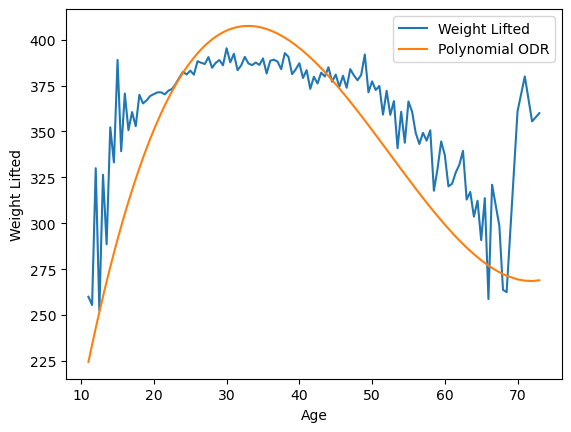

In [68]:
pord(total,'F',3)

Peak Mean Weight Lifted is at: 37.5 years old.
Recovered equation: y=158.99x + 22.72, t=6.82, p=2.16e-10
R_Squared: 0.8839065222433129


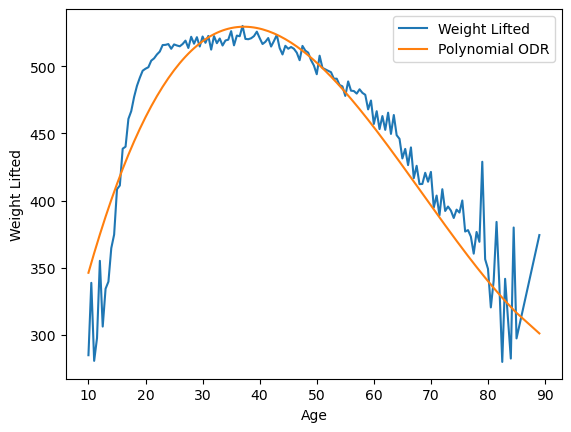

In [69]:
pord(total,'M',3)

Squat

Peak Mean Weight Lifted is at: 32.0 years old.
Recovered equation: y=19.35x + 9.32, t=1.52, p=1.30e-01
R_Squared: 0.6760767379643957


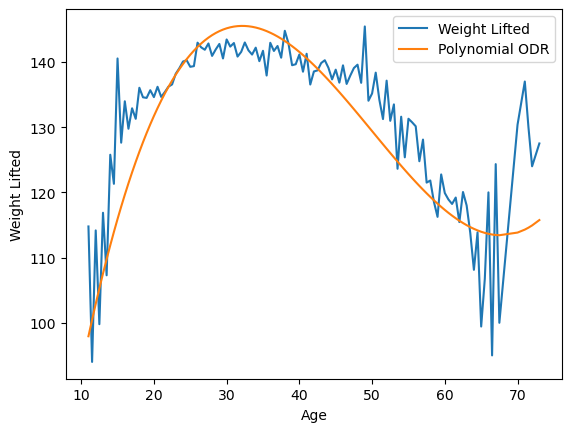

In [70]:
pord(squat,'F',3)

Peak Mean Weight Lifted is at: 38.0 years old.
Recovered equation: y=76.45x + 6.45, t=12.05, p=7.24e-24
R_Squared: 0.8651077629367996


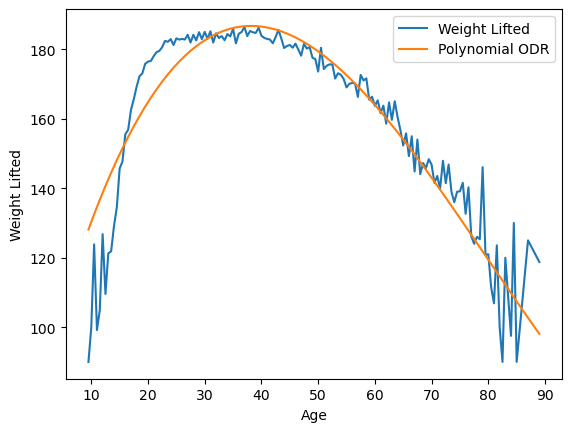

In [71]:
pord(squat,'M',3)

Bench

Peak Mean Weight Lifted is at: 37.5 years old.
Recovered equation: y=47.55x + 2.19, t=13.45, p=5.58e-26
R_Squared: 0.6999747453863772


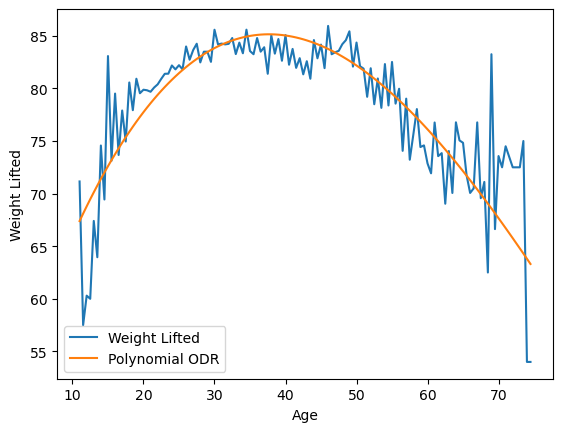

In [72]:
pord(bench,'F',3)

Peak Mean Weight Lifted is at: 39.0 years old.
Recovered equation: y=12.62x + 6.92, t=2.08, p=3.88e-02
R_Squared: 0.9130047884026455


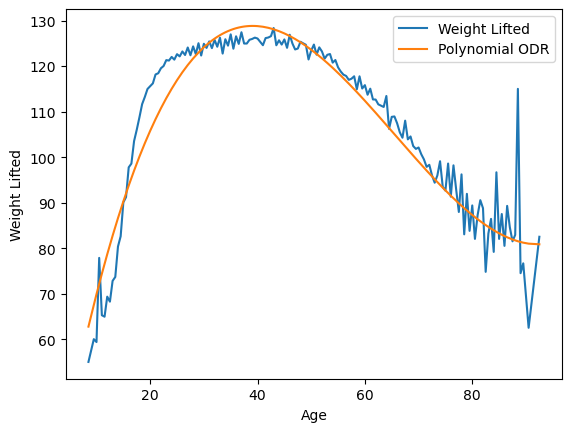

In [73]:
pord(bench,'M',3)

Deadlift

Peak Mean Weight Lifted is at: 35.5 years old.
Recovered equation: y=57.82x + 7.24, t=4.80, p=4.40e-06
R_Squared: 0.6717184750213829


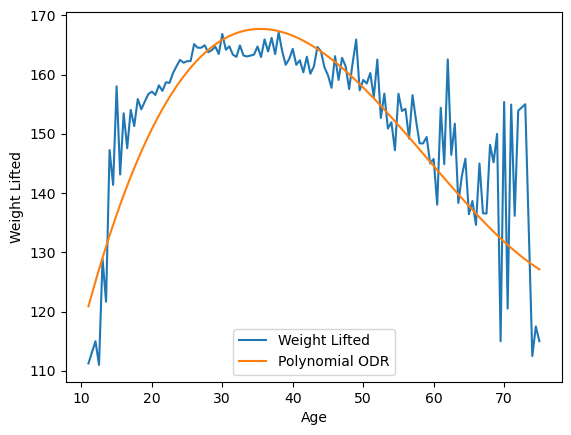

In [74]:
pord(dead,'F',3)

Peak Mean Weight Lifted is at: 37.5 years old.
Recovered equation: y=79.90x + 8.30, t=9.95, p=2.67e-18
R_Squared: 0.865632623038813


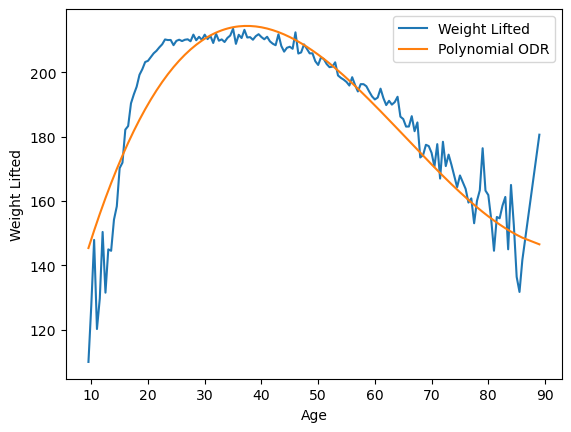

In [75]:
pord(dead,'M',3)

# Export Drug Tested Top Strength Population

Export the dataframe consisting of top 10% strength for each weight group

In [76]:
max_strength_df(total,'M').to_pickle('GP_Total_M.pkl')
max_strength_df(squat,'M').to_pickle('GP_Squat_M.pkl')
max_strength_df(bench,'M').to_pickle('GP_Bench_M.pkl')
max_strength_df(dead,'M').to_pickle('GP_Dead_M.pkl')

max_strength_df(total,'F').to_pickle('GP_Total_F.pkl')
max_strength_df(squat,'F').to_pickle('GP_Squat_F.pkl')
max_strength_df(bench,'F').to_pickle('GP_Bench_F.pkl')
max_strength_df(dead,'F').to_pickle('GP_Dead_F.pkl')